In [1]:
import pandas as pd
import numpy as np
from tsa.preprocessing import get_sample_info, tpm_normalization
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.tsa import best_alignment_graph
from tsa.utils import list2floats, inference_timeseries
from tsa.plotting import plot_alignments
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import zscore
from qnorm import quantile_normalize
import warnings
import sklearn
import random
from sklearn.cluster import k_means, KMeans
from sklearn.decomposition import PCA

### Median of Ratio normalization (Tilman)

In [2]:
def deseq2_norm(_data : pd.DataFrame):
    """
    Calculate the deseq2 median of ratios
    
    See for an **excellent** explanation statquest (as usual)
    https://www.youtube.com/watch?v=UFB993xufUU
    
    input data (as a pandas dataframe), e.g.:
    
            sample1    sample2    sample3
    gene1   0.00000    10.0000    4.00000
    gene2   2.00000    6.00000    12.0000
    gene3   33.5000    55.0000    200.000
    
    normalized output:
            sample1    sample2    sample3
    gene1   0.00000    10.6444    1.57882
    gene2   4.76032    6.38664    4.73646
    gene3   78.5453    58.5442    78.9410
    """
    # step 1: log normalize
    log_data = np.log(_data)

    # step 2: average rows
    row_avg = np.mean(log_data, axis=1)
    
    # step 3: filter rows with zeros
    rows_no_zeros = row_avg[row_avg != -np.inf].index
    
    # step 4: subtract avg log counts from log counts
    ratios = log_data.loc[rows_no_zeros].subtract(row_avg.loc[rows_no_zeros], axis=0)
    
    # step 5: calculate median of ratios
    medians = ratios.median(axis=0)
    
    # step 6: median -> base number
    scaling_factors = np.e ** medians
    print(scaling_factors)
    
    # step 7: normalize!
    normalized_data = _data / scaling_factors
    return normalized_data

In [3]:
def get_cost_matrix(template_tpms, query_tpms, metric='euclidean'):
    template = template_tpms.to_numpy(dtype=np.float64)
    query = query_tpms.to_numpy(dtype=np.float64)
    cost_matrix = cdist(template.T, query.T, metric=metric).T  # pairwise distance matrix
    return cost_matrix

In [4]:
# def plot_alignment(cost_matrix, best_path):
#     q = cost_matrix.index.to_list()
#     extended_template_time = list2floats(cost_matrix.columns)
#     t = [extended_template_time[i] for i in best_path]

#     plt.rcParams['figure.figsize'] = [8, 6]
    
#     plt.plot(q, t, alpha=0.5)
#     plt.scatter(q, t, s=10, color="black")
    
#     # add diagonal
#     start = min(t[0], q[0])
#     end = max(t[-1], q[-1])
#     plt.plot([start, end], [start, end], alpha=0.2, ls='--')
    
#     plt.title("local alignment")
#     plt.ylabel("template (mpf)")
#     plt.ylim(t[0], t[-1])
#     plt.xlabel("query (mpf)")
#     plt.xlim(q[0], q[-1])
#     plt.show()

def plot_alignment(cost_matrix, best_path, std_path=None):
    q = cost_matrix.index.to_list()
    extended_template_time = list2floats(cost_matrix.columns)
    t = [extended_template_time[i] for i in best_path]

    plt.rcParams['figure.figsize'] = [8, 6]
    
    plt.plot(q, t, alpha=0.5)
    plt.scatter(q, t, s=10, color="black")
    if std_path is not None:
        plt.errorbar(q, t, color="grey", yerr=std_path2, alpha=0.2, fmt='none')
    
    # add diagonal
    start = min(t[0], q[0])
    end = max(t[-1], q[-1])
    plt.plot([start, end], [start, end], alpha=0.2, ls='--')
    
    plt.title("local alignment")
    plt.ylabel("template (mpf)")
    plt.ylim(t[0], t[-1])
    plt.xlabel("query (mpf)")
    plt.xlim(q[0], q[-1])
    plt.show()
    
# df = pd.DataFrame(cost_matrix)
# df.columns = t.columns
# df.index = q.columns
# plot_alignment(df, best_path)

In [5]:
# template
template_samples_file = "data/white_mpf_samples.tsv"
gpr_inference_file = "data/white_mpf_gpr.tsv"
gpr_scores_file = "data/white_mpf_score.tsv"

# query
query_samples_file = "data/levin_mpf_samples.tsv"

# both
tpm_file = "data/GRCz11-TPM.tsv"
selected_genes_file = "data/white_genes.tsv"

### normalization tests

In [6]:
def tpm_normalization(
        tpms: pd.DataFrame,
        column_order: list,
) -> pd.DataFrame:    
    bc = tpms[column_order]                       # filter & order samples    
    
    # default
    bc = quantile_normalize(bc, axis=1)           # normalize        
    bc = np.log2(bc+1)                            # transform
    
#     bc = deseq2_norm(bc)                          # normalize       
#     bc = np.log2(bc+1)                            # transform

#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore", category=RuntimeWarning)
#         bc = pd.DataFrame(zscore(bc, axis=1), columns = bc.columns, index=bc.index)  # normalize
#         bc = np.log2(bc+1).dropna()                           # transform

#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore", category=RuntimeWarning)
#
# #         bc = quantile_normalize(bc, axis=1)             # normalize between samples
#         bc = deseq2_norm(bc)                          # normalize between samples
#         bc.fillna(0, inplace=True)
#       
#         bc = pd.DataFrame(zscore(bc, axis=1), columns = bc.columns, index=bc.index)  # normalize
#         bc.fillna(0, inplace=True)
#
# #         bc = quantile_normalize(bc, axis=1)                 # normalize
# #         bc = deseq2_norm(bc)                                # normalize
# 
#         bc = np.log2(bc+1)                                    # transform
#         bc.fillna(0, inplace=True)

    return bc

In [163]:
# # SANITY CHECK: ZSCORE AXIS must be 1


# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
# selected_genes = list(pd.read_csv(selected_genes_file, sep="\t")["gene"])
# tpms = tpms[tpms.index.isin(selected_genes)]
# tpms = tpms[tpms.index.isin(["ENSDARG00000000212", "ENSDARG00000002768", "ENSDARG00000002165", "ENSDARG00000002445"])]

# print("raw")
# gene = tpms.loc["ENSDARG00000002768"]
# print(gene.mean())
# print(gene.std())
# print()

# print("znorm single gene")
# gene = zscore(tpms.loc["ENSDARG00000002768"])
# print(gene.mean())
# print(gene.std())
# print()

# print("znorm df axis=0")
# bc = tpms.copy()
# bc = pd.DataFrame(zscore(bc, axis=0), columns = bc.columns, index=bc.index)

# gene = bc.loc["ENSDARG00000002768"]
# print(gene.mean())
# print(gene.std())
# print()

# print("znorm df axis=1")
# bc = tpms.copy()
# bc = pd.DataFrame(zscore(bc, axis=1), columns = bc.columns, index=bc.index)

# gene = bc.loc["ENSDARG00000002768"]
# print(gene.mean())
# print(gene.std())

### plot normalized gene expression alignment (without TSA)

In [252]:
# preprocessing
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
selected_genes = list(pd.read_csv(selected_genes_file, sep="\t")["gene"])
tpms = tpms[tpms.index.isin(selected_genes)]

timepoints_per_sample = 10

query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)
query_tpms = tpm_normalization(tpms, sample_order)

template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)
template_tpms = tpm_normalization(tpms, template_sample_order)

# filter genes for simplicity
template_tpms = template_tpms[template_tpms.index.isin(["ENSDARG00000000212", "ENSDARG00000002768", "ENSDARG00000002165", "ENSDARG00000002445"])]

extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)
template_tpms_inf, _ = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)

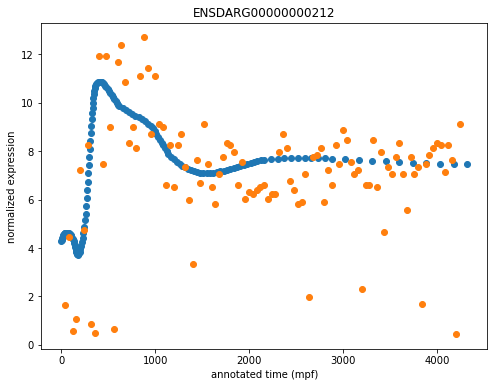

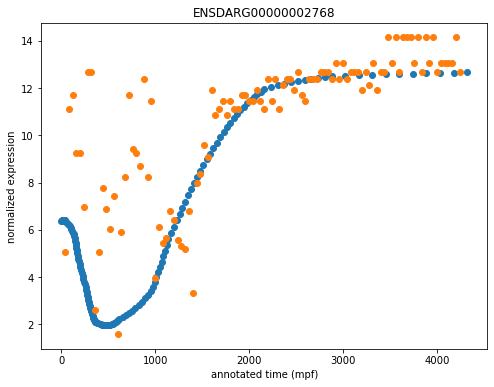

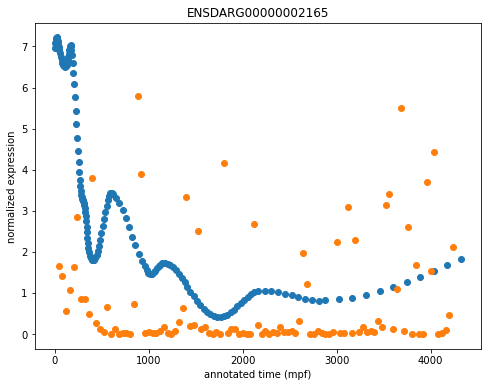

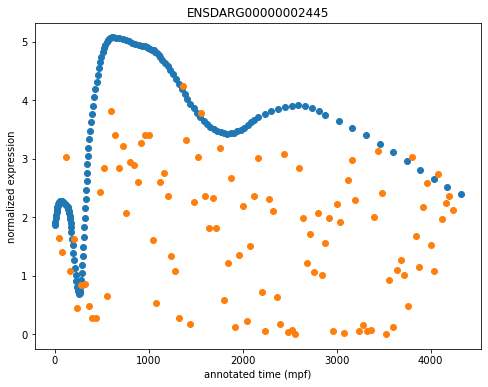

In [251]:
good_genes = ["ENSDARG00000000212", "ENSDARG00000002768", "ENSDARG00000004232", "ENSDARG00000005023", "ENSDARG00000006110", "ENSDARG00000006427"]
bad_genes = ["ENSDARG00000002165", "ENSDARG00000002445", "ENSDARG00000002601"]
genes = good_genes[0:2] + bad_genes[0:2]
# genes = good_genes

extended_template_time = list2floats(template_tpms_inf.columns)
x_template = extended_template_time[:151]

plt.rcParams['figure.figsize'] = [8, 6] 

x_query = list(time2samples)
for gene in genes:  # query_tpms.index: #
    y_template = template_tpms_inf.loc[gene].to_list()[:151]
    plt.scatter(x=x_template, y=y_template)
    
    y_query = query_tpms.loc[gene]
    plt.scatter(x=x_query, y=y_query)
    
    plt.title(gene)
    plt.ylabel("normalized expression")
    plt.xlabel("annotated time (mpf)")
    plt.show()

### gene selection

In [7]:
# preprocessing
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
selected_genes = list(pd.read_csv(selected_genes_file, sep="\t")["gene"])
tpms = tpms[tpms.index.isin(selected_genes)]

timepoints_per_sample = 10

query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)
query_tpms = tpm_normalization(tpms, sample_order)

template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)
template_tpms = tpm_normalization(tpms, template_sample_order)

extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)
template_tpms_inf, _ = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)



samples2time = {}
for k, v_list in time2samples.items():
    for v in v_list:
        if v not in samples2time:
            samples2time[v] = k

### gene selection: specific subsets

In [8]:
# filter for genes highly variable in the query
delta = []
for gene in query_tpms.iterrows():
    delta.append(np.abs(np.diff(list(gene[1]))).sum())
df = query_tpms.copy()
df["delta"] = delta
hvar_genes = df.sort_values("delta", ascending=False).head(200).index.to_list()

In [9]:
good_genes = ["ENSDARG00000000212", "ENSDARG00000002768", "ENSDARG00000004232", "ENSDARG00000005023", "ENSDARG00000006110", "ENSDARG00000006427"]
bad_genes = ["ENSDARG00000002165", "ENSDARG00000002445", "ENSDARG00000002601"]

TSA based on 1 genes

------------------------------------------------------
euclidean


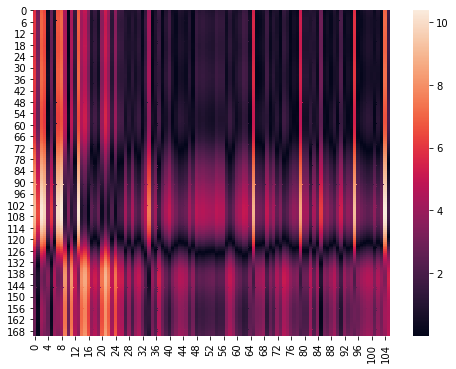

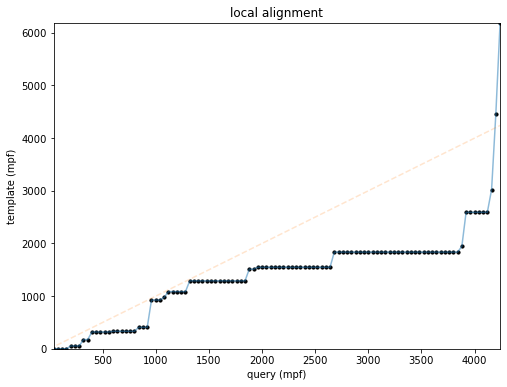

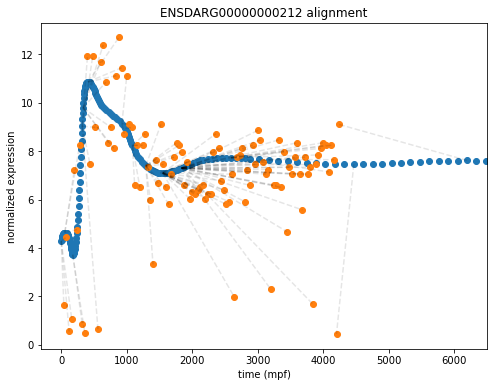

------------------------------------------------------
correlation


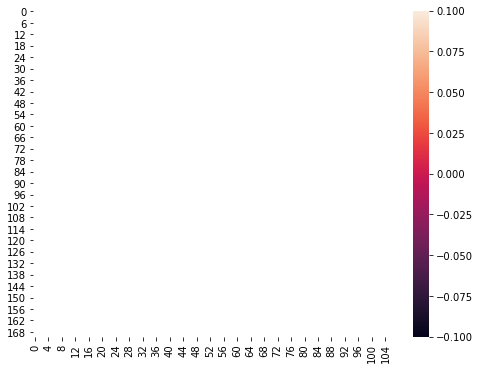

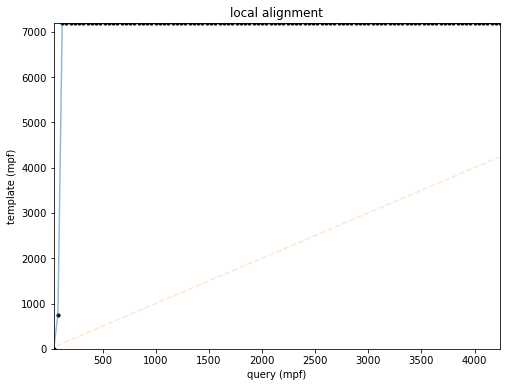

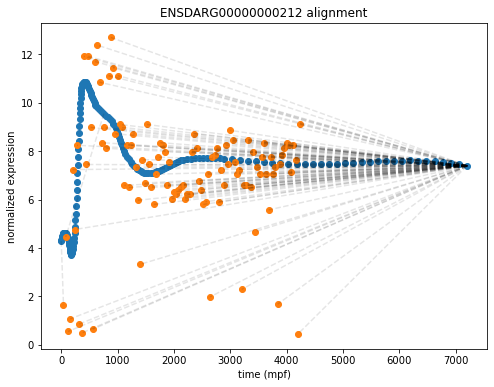

------------------------------------------------------
cosine


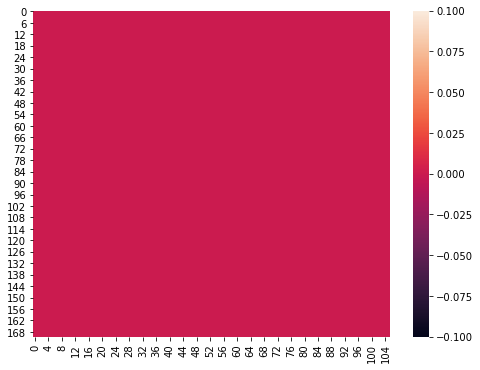

<ipython-input-36-50b0ef227d9b>:18: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim(t[0], t[-1])


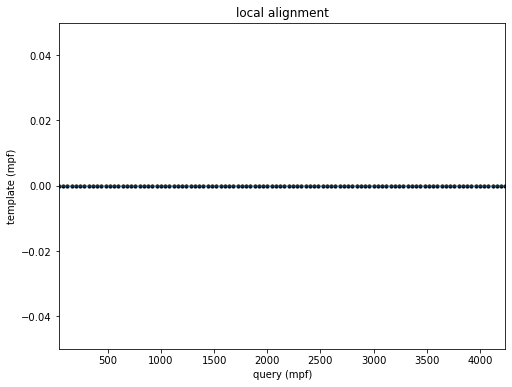

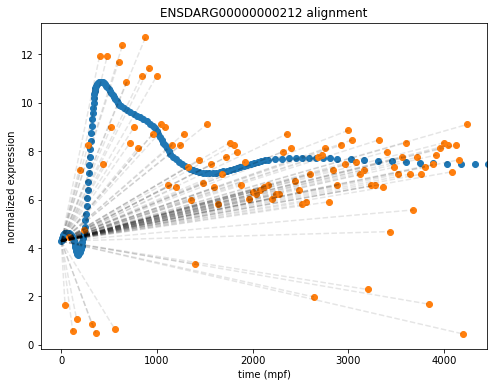

In [358]:
genes =  ["ENSDARG00000000212"]  # ["ENSDARG00000002165"]  #good_genes  # hvar_genes[0:10]  # good_genes[0:1]  # query_tpms.index #  good_genes#[-4:]  

samples2time = {}
for k, v_list in time2samples.items():
    for v in v_list:
        if v not in samples2time:
            samples2time[v] = k

t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
# t = template_tpms.copy()
# for timepoint in template_time2samples:
#     t[timepoint] = t[template_time2samples[timepoint]].mean(axis=1)
# t = t.filter(items=template_time2samples.keys())
# t = t[t.index.isin(genes)]

q = query_tpms[query_tpms.index.isin(genes)].rename(columns=samples2time)

metrics = ['euclidean', "correlation", "cosine"]
# metrics = ["braycurtis", "canberra", "chebyshev", "correlation", "cosine", "euclidean", "jensenshannon", "minkowski", "seuclidean", "sqeuclidean"]
# metrics = ['euclidean']
print("TSA based on", len(q.index), "genes\n")
for metric in metrics:
    print("------------------------------------------------------")
    print(metric)
    try:
        cost_matrix = get_cost_matrix(t, q, metric)
    except:
        print("failed")
        continue

    # plot heatmap
    # matrix flipped to go from bottom left to top right.
    sns.heatmap(cost_matrix[:,::-1].T)
    plt.show()
    
    # LTSA
    best_path, best_score = best_alignment_graph(cost_matrix)
    
    # plot LTSA
    df = pd.DataFrame(cost_matrix)
    df.columns = t.columns
    df.index = q.columns
    plot_alignment(df, best_path)
    
    # mapping
    query_time = list2floats(query_samples.time.unique())
    extended_template_time = list2floats(t.columns)
    mapped = pd.DataFrame(data={
        "original_time": query_time,
        "inferred_time": [extended_template_time[i] for i in best_path],
    })

    # plot alignment
    x1 = extended_template_time
    x2 = mapped.original_time.to_list()
    for gene in q.index:
        y1 = t.loc[gene].to_list()
        y2 = q.loc[gene].to_list() 

        plt.scatter(x=x1, y=y1)
        plt.scatter(x=x2, y=y2)
#         plt.plot(x2, y2)
        for n in range(len(x2)):
            m = best_path[n]
            plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')

        # pretty stuff
        plt.title(f"{gene} alignment")
        plt.ylabel("normalized expression")
        plt.xlabel("time (mpf)")
        start = x1[best_path[0]]
        end = max(x1[best_path[-1]], x2[-1])
        a_bit = (end - start) * 0.05
        plt.xlim(start - a_bit, end + a_bit)
        plt.show()
        
        break
        
# print(t.loc[gene])
# print(q.loc[gene])
# pd.DataFrame(cost_matrix, columns=t.columns, index=q.columns)

### gene selection: average of 100 random subsets of 100 genes  (Maarten)

In [14]:
tries = 100
paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(int(100*n/tries), "%")
    genes = random.sample(query_tpms.index.to_list(), 100)

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)].rename(columns=samples2time)

    cost_matrix = get_cost_matrix(t, q, metric='euclidean')
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path

0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %


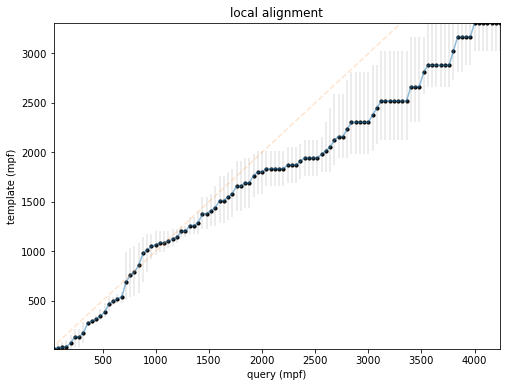

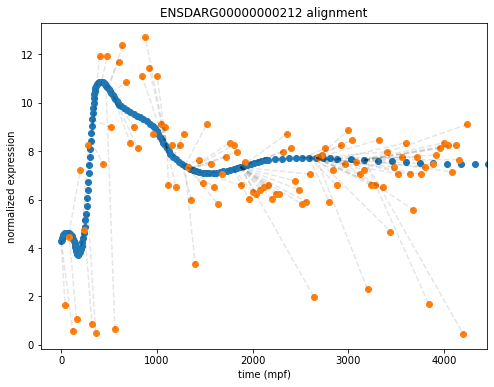

In [15]:
avg_path = [int(i) for i in paths.mean(axis=0)]

# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        print(n)
        avg_path[n] = avg_path[n-1]
    

std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
#     std_time = (std_time_max + std_time_min)/2
#     std_path2.append(std_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T


# plot LTSA
df = pd.DataFrame(cost_matrix)
df.columns = t.columns
df.index = q.columns
def plot_alignment(cost_matrix, best_path, std_path=None):
    q = cost_matrix.index.to_list()
    extended_template_time = list2floats(cost_matrix.columns)
    t = [extended_template_time[i] for i in best_path]

    plt.rcParams['figure.figsize'] = [8, 6]
    
    plt.plot(q, t, alpha=0.5)
    plt.scatter(q, t, s=10, color="black")
    if std_path is not None:
        # error bubble. points scaled to roughly the same size as the bars would be
#         plt.scatter(q, t, s=[n*8 for n in std_path2], color="black", alpha=0.05)
        plt.errorbar(q, t, color="grey", yerr=std_path2, alpha=0.2, fmt='none')
    
    # add diagonal
    start = min(t[0], q[0])
    end = max(t[-1], q[-1])
    plt.plot([start, end], [start, end], alpha=0.2, ls='--')
    
    plt.title("local alignment")
    plt.ylabel("template (mpf)")
    plt.ylim(t[0], t[-1])
    plt.xlabel("query (mpf)")
    plt.xlim(q[0], q[-1])
    plt.show()

plot_alignment(df, avg_path, std_path2)
    
# mapping
query_time = list2floats(query_samples.time.unique())
extended_template_time = list2floats(t.columns)
mapped = pd.DataFrame(data={
    "original_time": query_time,
    "inferred_time": [extended_template_time[i] for i in avg_path],
})

# plot alignment
x1 = extended_template_time
y1 = template_tpms_inf.loc["ENSDARG00000000212"].to_list()

x2 = mapped.original_time.to_list()
y2 = query_tpms.loc["ENSDARG00000000212"].to_list() 

plt.scatter(x=x1, y=y1)
plt.scatter(x=x2, y=y2)
for n in range(len(x2)):
    m = best_path[n]
    plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')

# pretty stuff
plt.title("ENSDARG00000000212 alignment")
plt.ylabel("normalized expression")
plt.xlabel("time (mpf)")
start = x1[best_path[0]]
end = max(x1[best_path[-1]], x2[-1])
a_bit = (end - start) * 0.05
plt.xlim(start - a_bit, end + a_bit)
plt.show()

### gene selection: bootstrap to find best fitting genes  (Jos)

In [169]:
genes = query_tpms.index.to_list()

names_query = query_tpms.rename(columns=samples2time)
query_time = list2floats(query_samples.time.unique())
extended_template_time = list2floats(template_tpms_inf.columns)

def nearest(myNumber, myList):
    return min(myList, key=lambda x:abs(x-myNumber))

clostest_times = [nearest(i, extended_template_time) for i in query_time]

scores = [] 
for gene in genes:
    template_y = template_tpms_inf.loc[gene][clostest_times]
    query_y = names_query.loc[gene]   
    # how close are the two time series? (argument order is arbitrary)
    scores.append(sklearn.metrics.r2_score(y_true=query_y, y_pred=template_y))
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html  
    
best_fitting_genes = pd.DataFrame({"gene": genes, "score": scores}).sort_values("score", ascending=False)
print(len(best_fitting_genes))
best_fitting_genes.head(3)

264


gene     score
83   ENSDARG00000035957  0.673694
172  ENSDARG00000070546  0.598286
227  ENSDARG00000099493  0.570048

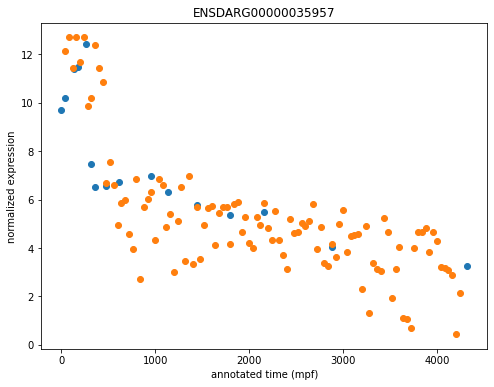

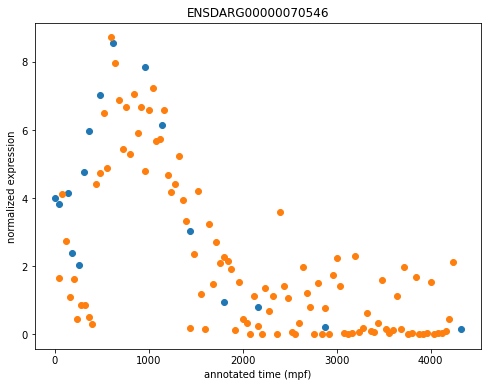

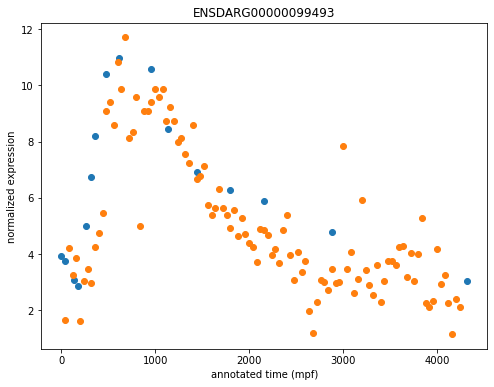

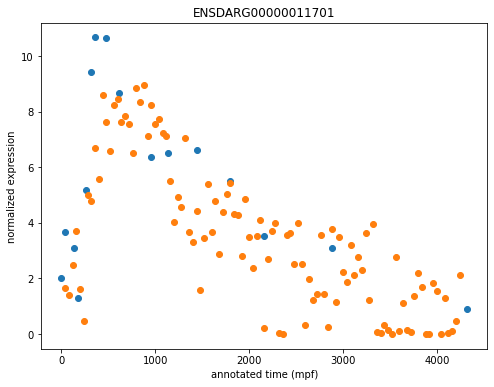

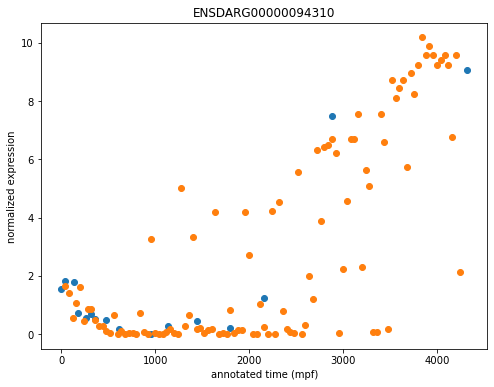

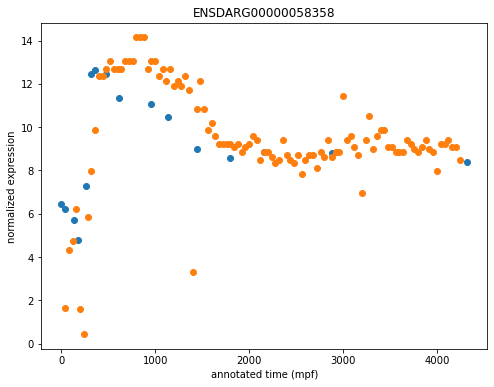

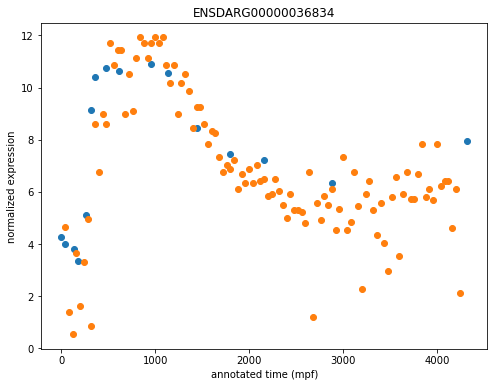

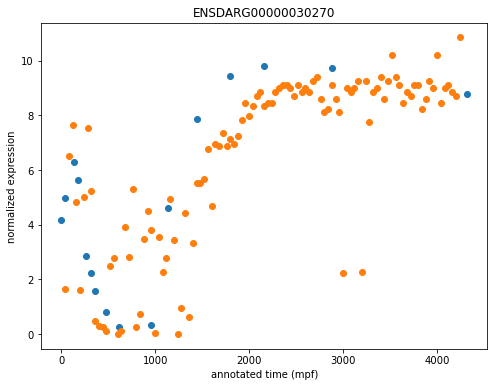

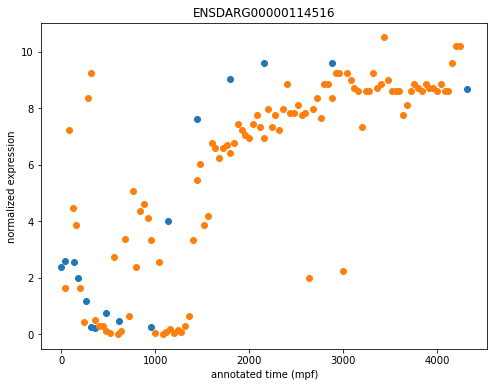

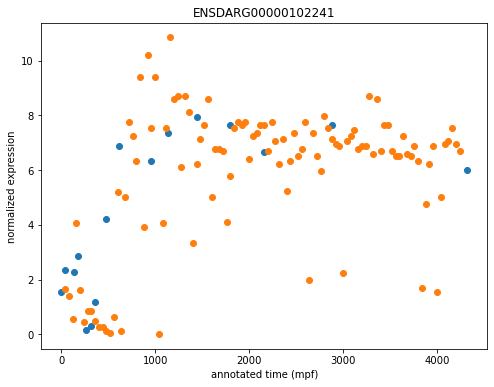

In [170]:
# plot result on non-inferred template data

for gene in best_fitting_genes.head(10).gene.to_list():
    # gene = "ENSDARG00000055973"

    # average replicates
    t = template_tpms.copy()
    for timepoint in template_time2samples:
        t[timepoint] = t[template_time2samples[timepoint]].mean(axis=1)
    t = t.filter(items=template_time2samples.keys())
    x_template = list(template_time2samples)[:-2]

    x_query = list(time2samples)

    y_template = t.loc[gene].to_list()[:-2]
    plt.scatter(x=x_template, y=y_template)

    y_query = query_tpms.loc[gene]
    plt.scatter(x=x_query, y=y_query)

    plt.title(gene)
    plt.ylabel("normalized expression")
    plt.xlabel("annotated time (mpf)")
    plt.show()

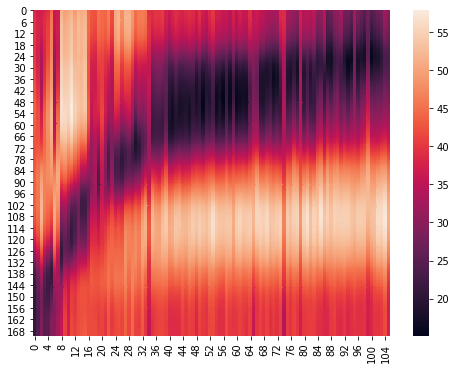

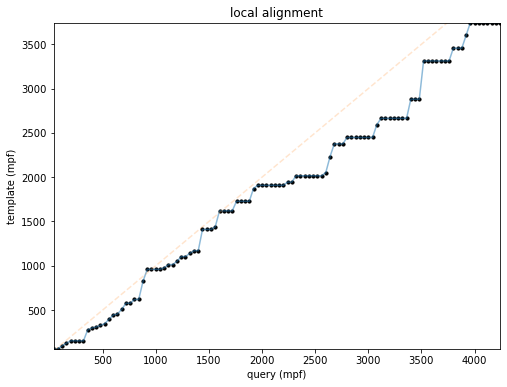

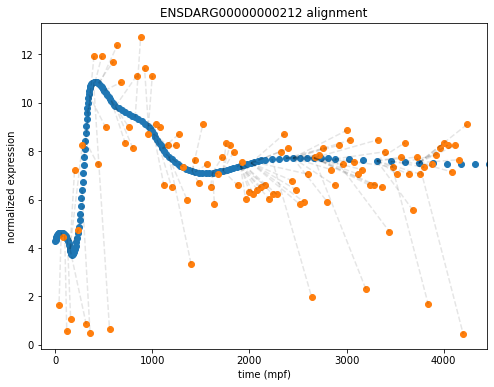

In [171]:
genes =  best_fitting_genes.head(100).gene.to_list()  # best fitting genes between template and query by annotation

t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
q = query_tpms[query_tpms.index.isin(genes)].rename(columns=samples2time)

query_time = list2floats(query_samples.time.unique())
extended_template_time = list2floats(t.columns)

metrics = ['euclidean']#, "correlation", "cosine"]
for metric in metrics:
    cost_matrix = get_cost_matrix(t, q, metric)

    # plot heatmap
    # matrix flipped to go from bottom left to top right.
    sns.heatmap(cost_matrix[:,::-1].T)
    plt.show()
    
    # LTSA
    best_path, best_score = best_alignment_graph(cost_matrix)
    
    # plot LTSA
    df = pd.DataFrame(cost_matrix)
    df.columns = t.columns
    df.index = q.columns
    plot_alignment(df, best_path)
    
    # mapping
    mapped = pd.DataFrame(data={
        "original_time": query_time,
        "inferred_time": [extended_template_time[i] for i in best_path],
    })

    # plot alignment
    x1 = extended_template_time
    x2 = query_time
    for gene in q.index:
        y1 = t.loc[gene].to_list()
        y2 = q.loc[gene].to_list() 

        plt.scatter(x=x1, y=y1)
        plt.scatter(x=x2, y=y2)
        for n in range(len(x2)):
            m = best_path[n]
            plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')

        # pretty stuff
        plt.title(f"{gene} alignment")
        plt.ylabel("normalized expression")
        plt.xlabel("time (mpf)")
        start = x1[best_path[0]]
        end = max(x1[best_path[-1]], x2[-1])
        a_bit = (end - start) * 0.05
        plt.xlim(start - a_bit, end + a_bit)
        plt.show()
        
        break

### gene selection: cluster/PCA (Joost)

In [ ]:
# PCA/cluster on query genes 

# visually inspect genes per cluster

# find several best fitting genes per cluster

# TSA

In [278]:
# pre-filter for genes somewhat matching in both template and query
pre_filtered_genes = best_fitting_genes[best_fitting_genes.score >= 0.1].head(250).gene.to_list()
print("genes", len(pre_filtered_genes))
test_df = query_tpms[query_tpms.index.isin(pre_filtered_genes)]

# select number of clusters based on the number of genes
n_clusters = max(10, int(len(pre_filtered_genes)/20))
print("n_clusters:", n_clusters)

genes 76
n_clusters: 10


In [131]:
# select number of clusters based on smallest cluster size
# WORKS POORLY

# n_clusters = 10
# target_min_luster_size = int(len(query_tpms)/30)
# print("target_min_luster_size", target_min_luster_size)
# while n_clusters > 1:
#     print("clusters:", n_clusters)
    
#     k = k_means(
#         X = query_tpms,  # (n_samples, n_features)
#         n_clusters = n_clusters,
#     )

#     df = pd.DataFrame({"gene": query_tpms.index, "cluster": k[1]})#.sort_values("score", ascending=False)
#     for n in range(n_clusters):
#         genes = df[df.cluster == n].gene.to_list()
#         if len(genes) < target_min_luster_size:
#             print("small clusters", len(genes))
#             n_clusters = n_clusters-1
#             break
#     else:
#         break

# print("final cluster number", n_clusters)

In [279]:
# Kmean method test

# PCA of the data
reduced_data = PCA(n_components=2).fit_transform(test_df)

# 2 skealrn kmeans clustering methods
kmeans = KMeans(n_clusters=10, random_state=1234, n_init=1).fit(reduced_data)
k2 = kmeans.predict(reduced_data)
k1 = k_means(reduced_data, n_clusters=10, random_state=1234, n_init=1)[1]

# are they the same?
comp = set([n for n in zip(k_means(reduced_data, 10)[1], kmeans.predict(reduced_data))])
print(len(comp) == 10)

# both methods return the same if each cluster in method 1 corresponds to 1 cluster in method 2
# (even if the numbers dont match)

False


cluster 0


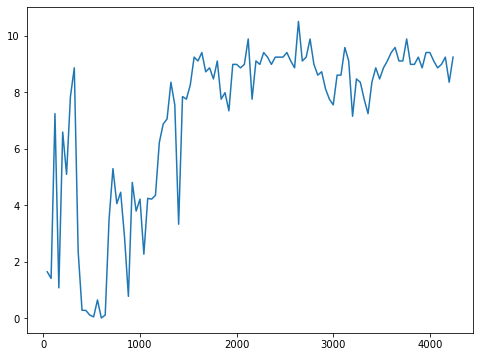

------------------------------------------------------------
cluster 1


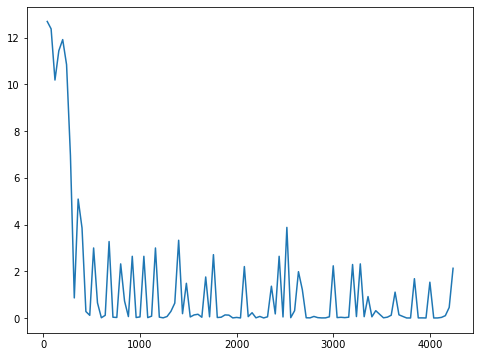

------------------------------------------------------------
cluster 2


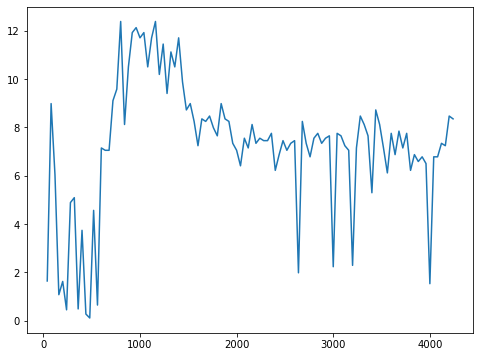

------------------------------------------------------------
cluster 3


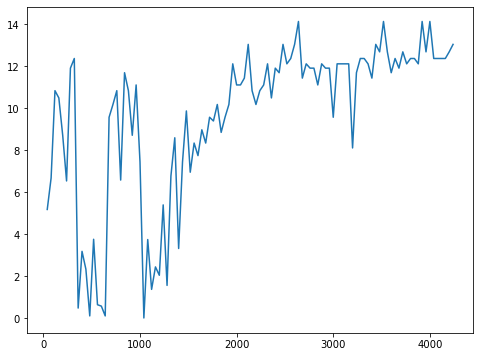

------------------------------------------------------------
cluster 4


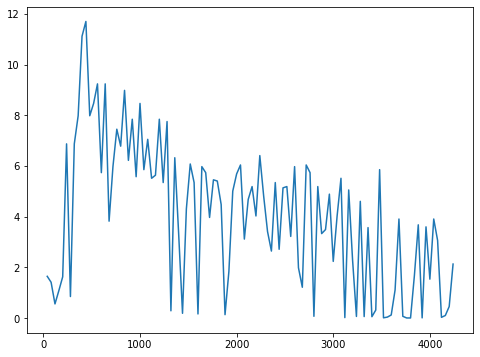

------------------------------------------------------------
cluster 5


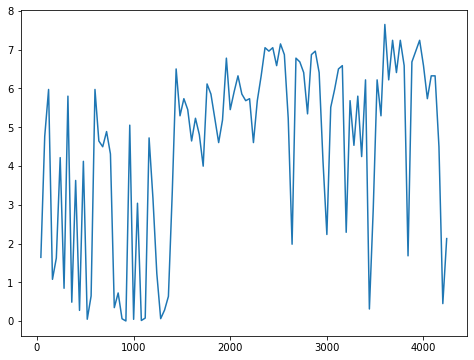

------------------------------------------------------------
cluster 6


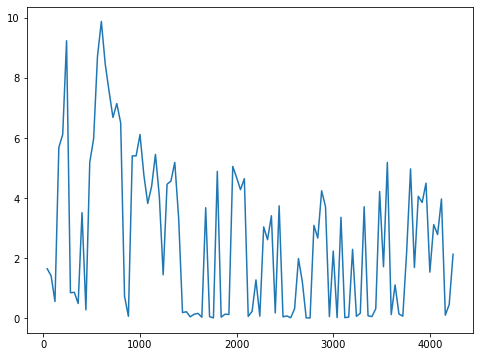

------------------------------------------------------------
cluster 7


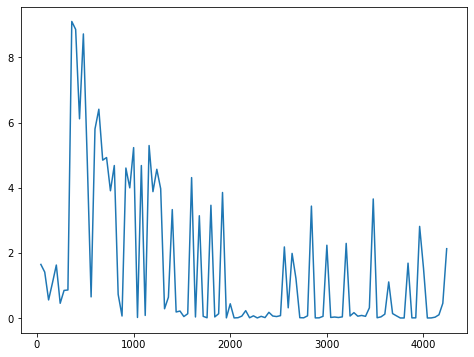

------------------------------------------------------------
cluster 8


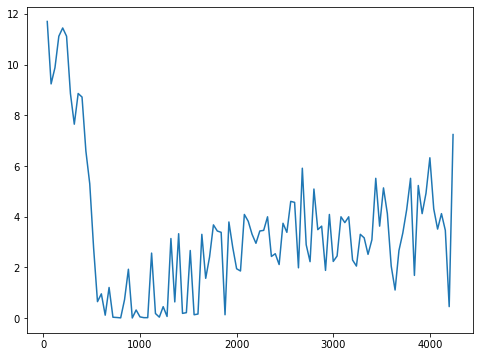

------------------------------------------------------------
cluster 9


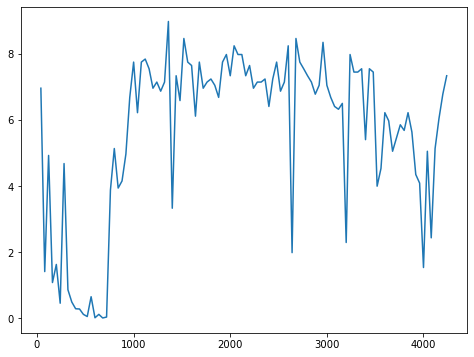

------------------------------------------------------------


In [286]:
# # K-means on normalized TPMS
# k = k_means(
#     X = test_df,  # (n_samples, n_features)
#     n_clusters = n_clusters,
# )
# gene_clusters = pd.DataFrame({"gene": test_df.index, "cluster": k[1]})

# # K-means on PCA (fit-predicted)
# reduced_data = PCA(n_components=2).fit_transform(test_df)
# kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
# kmeans.fit(reduced_data)
# k = kmeans.predict(reduced_data)
# gene_clusters = pd.DataFrame({"gene": test_df.index, "cluster": k})

# K-means on PCA
reduced_data = PCA(n_components=2).fit_transform(test_df)
k = k_means(reduced_data, n_clusters)[1]
gene_clusters = pd.DataFrame({"gene": test_df.index, "cluster": k})

q = query_tpms.rename(columns=samples2time)
for n in range(n_clusters):
    print("cluster", n)
    genes = gene_clusters[gene_clusters.cluster == n].gene.to_list()

    plots = 0
    for gene in genes:
        q.loc[gene].plot()
        plt.show()
        
        plots += 1
        if plots == 1:
            print("------------------------------------------------------------")
            break

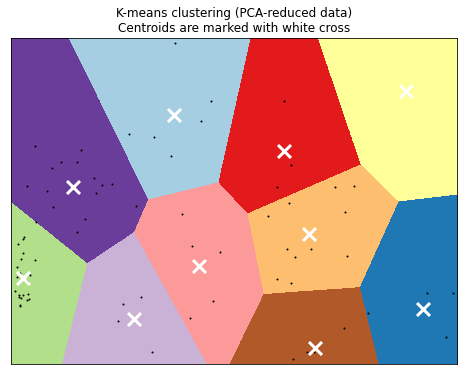

In [282]:
from sklearn.datasets import load_digits

# data = test_df  # query_tpms
# n_clusters = 8

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [287]:
max_genes_per_cluster = 12

df = best_fitting_genes.merge(gene_clusters, on="gene", how="inner")
# df.sort_values("score", ascending=False, inplace=True)
# df = df[df.score >= 0]

best_genes_per_cluster = []
for clust in set(df.cluster):
    clust_df = df[df.cluster == clust]
    n = min(max_genes_per_cluster, len(clust_df))
    
    clust_genes = clust_df.head(n).gene.to_list()
    print("cluster", clust, "contributes", len(clust_genes), "gene(s)")
    
    best_genes_per_cluster.extend(clust_genes)

len(best_genes_per_cluster)

cluster 0 contributes 4 gene(s)
cluster 1 contributes 12 gene(s)
cluster 2 contributes 7 gene(s)
cluster 3 contributes 4 gene(s)
cluster 4 contributes 6 gene(s)
cluster 5 contributes 4 gene(s)
cluster 6 contributes 9 gene(s)
cluster 7 contributes 7 gene(s)
cluster 8 contributes 5 gene(s)
cluster 9 contributes 8 gene(s)


66

In [ ]:
# get a number of genes such that the clusters contribute proportionally

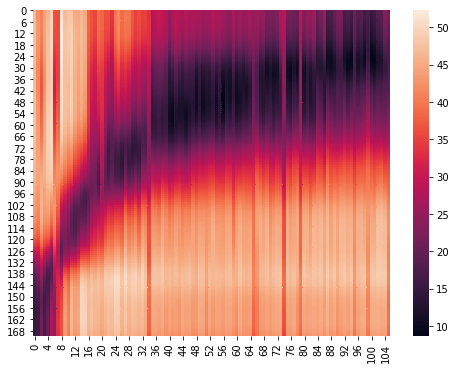

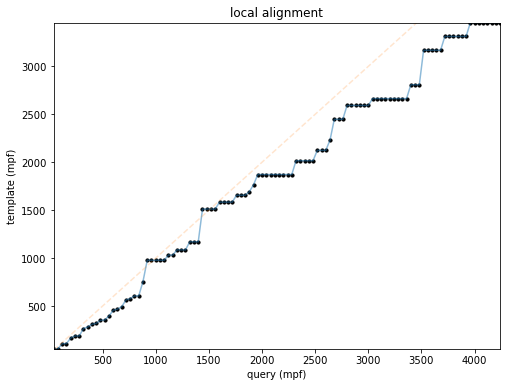

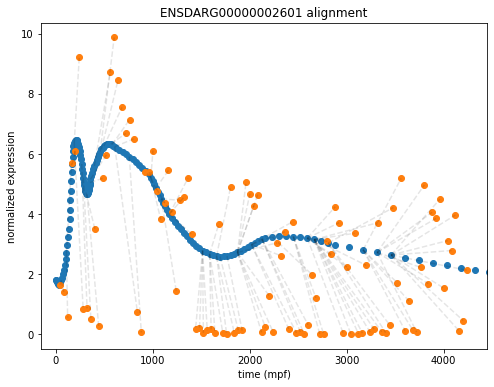

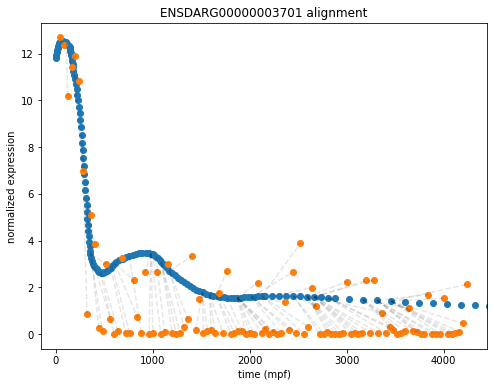

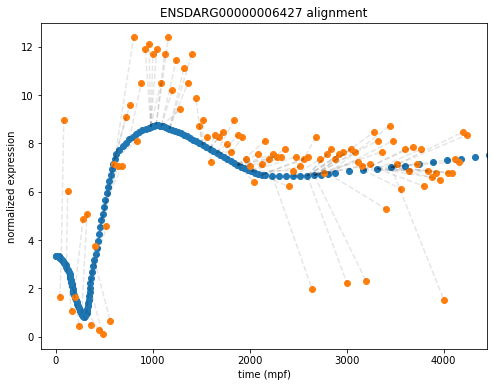

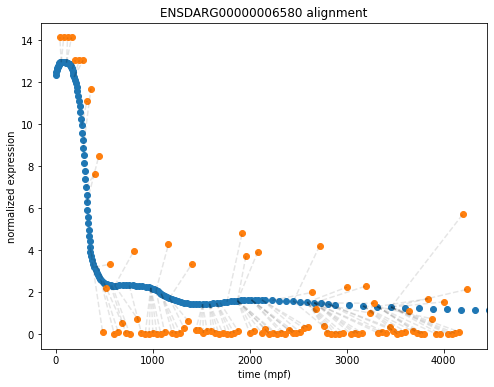

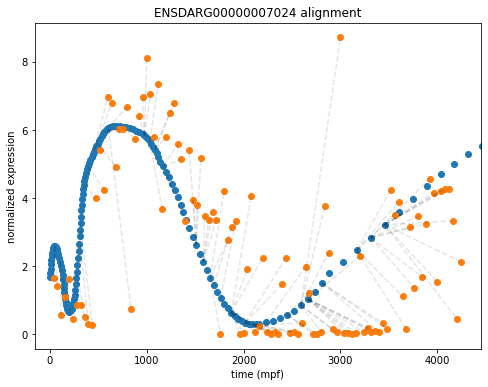

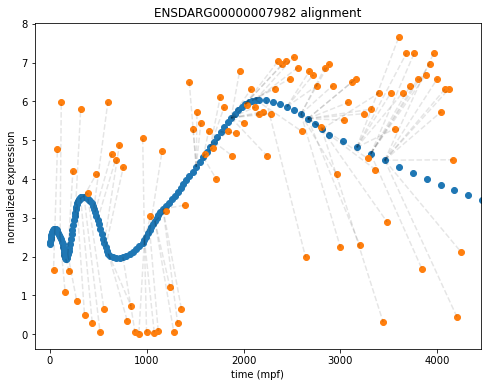

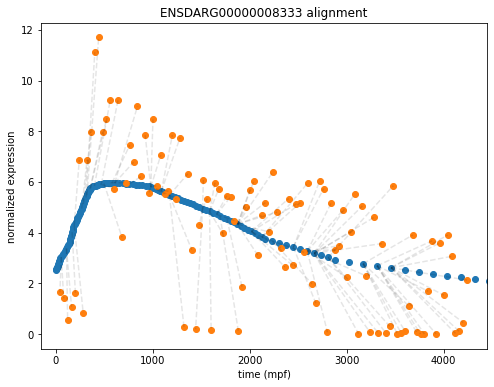

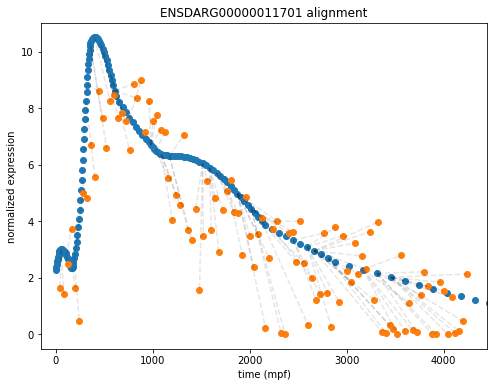

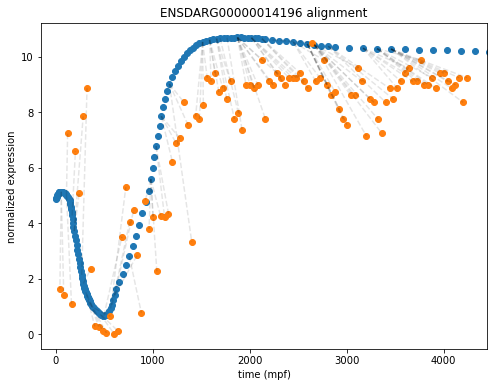

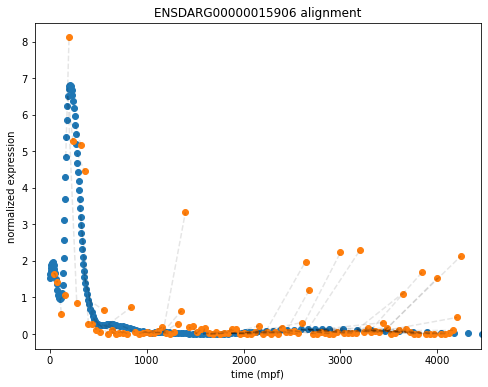

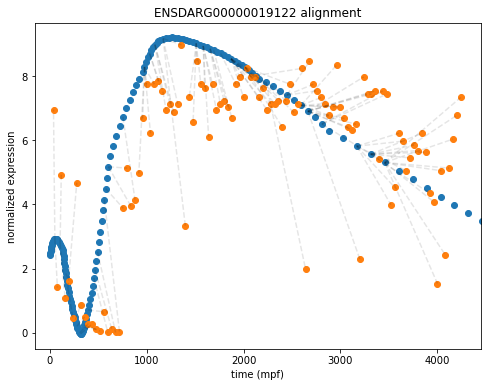

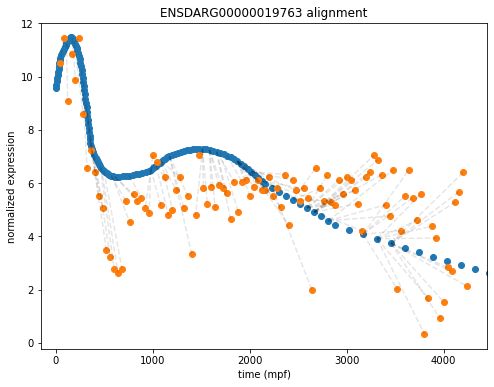

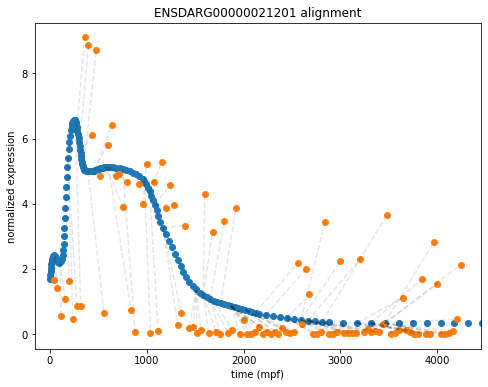

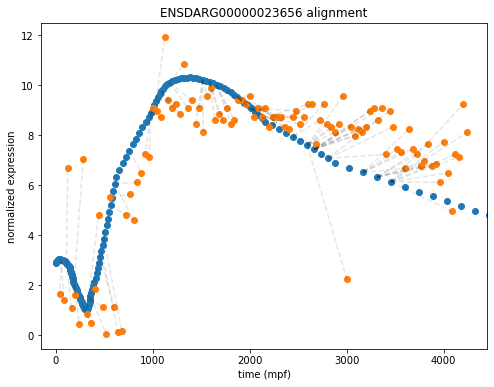

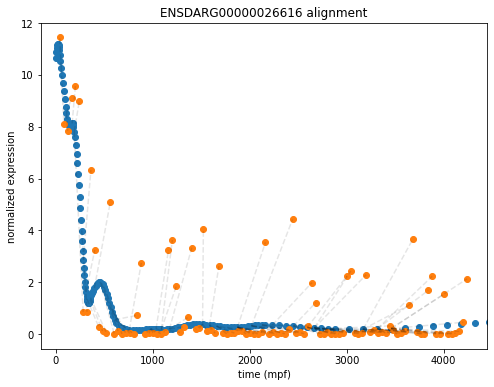

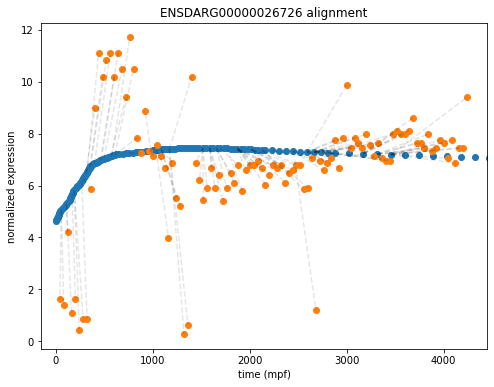

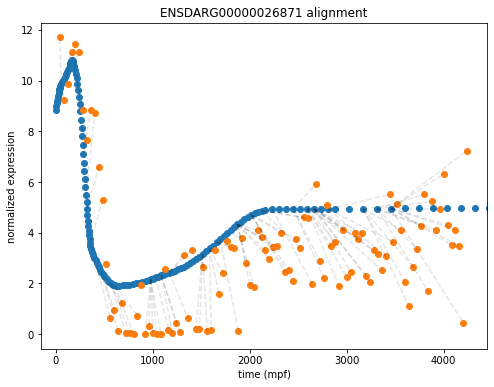

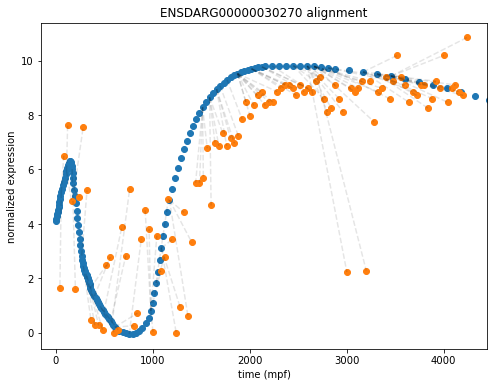

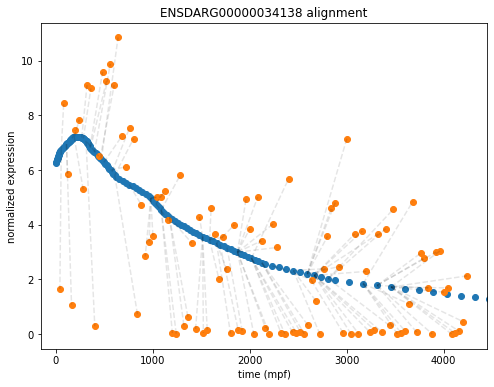

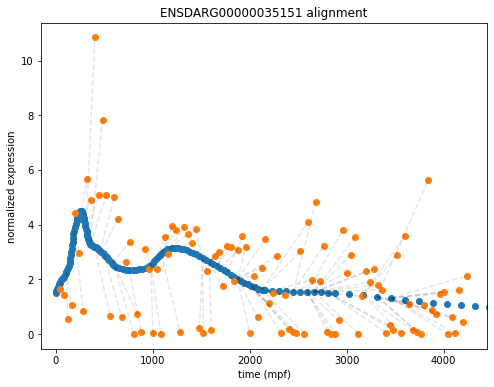

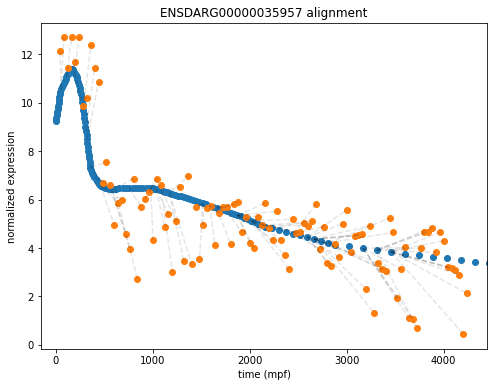

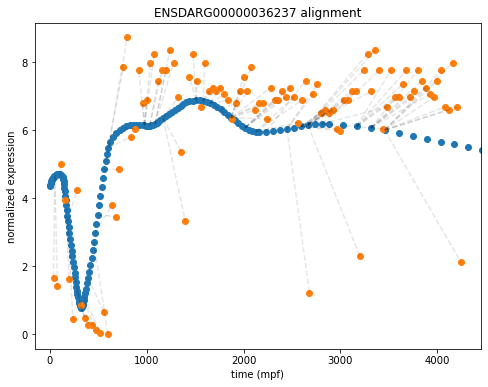

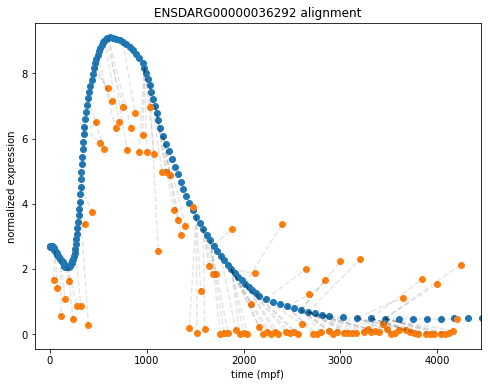

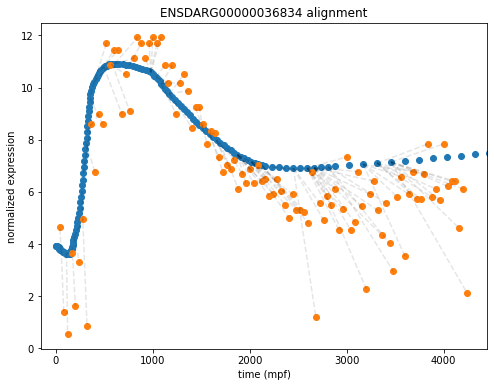

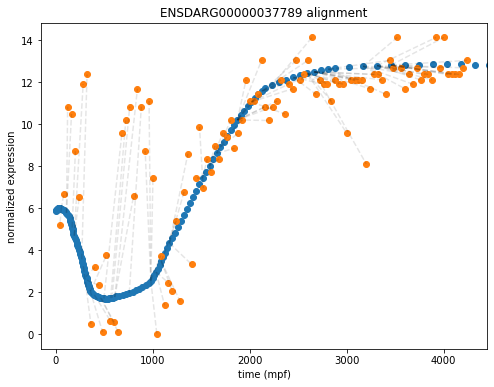

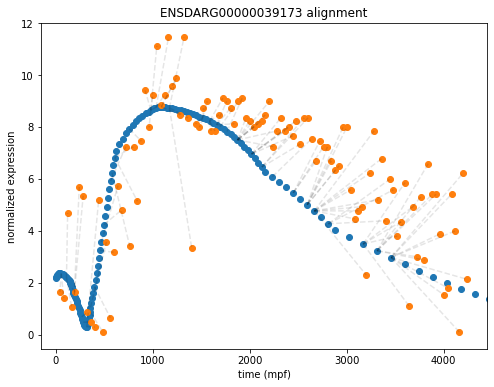

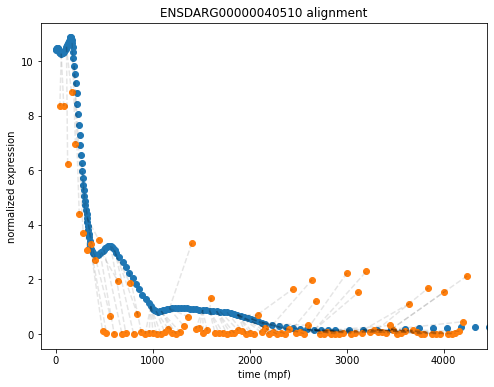

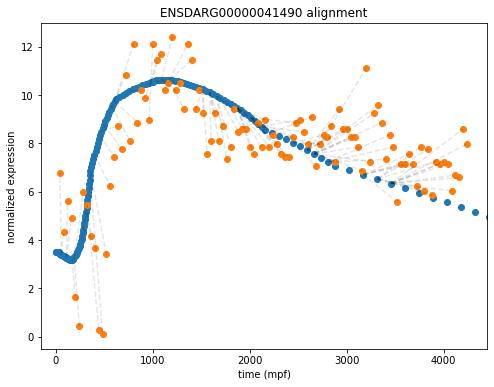

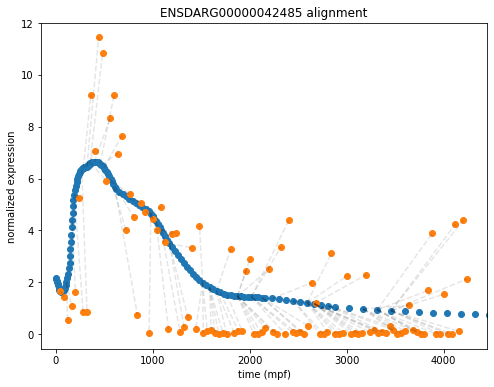

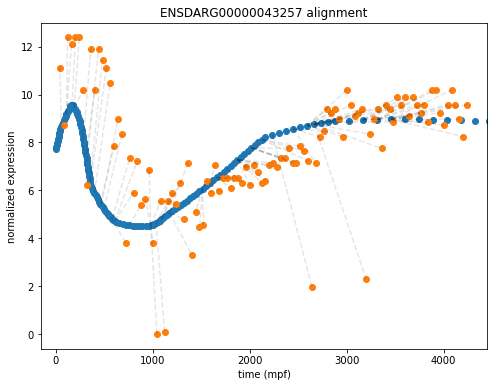

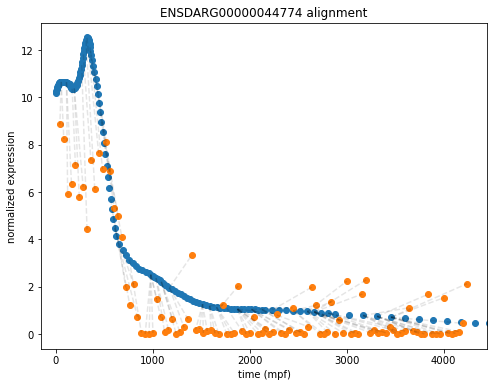

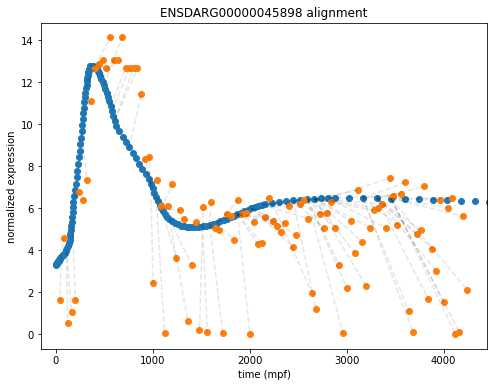

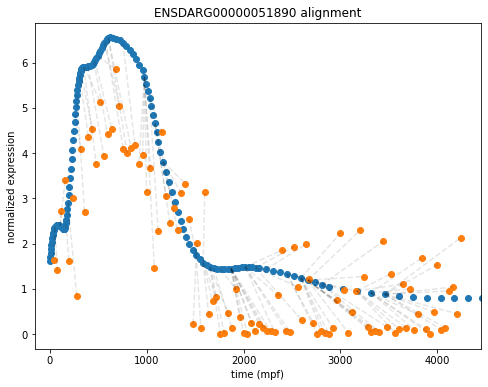

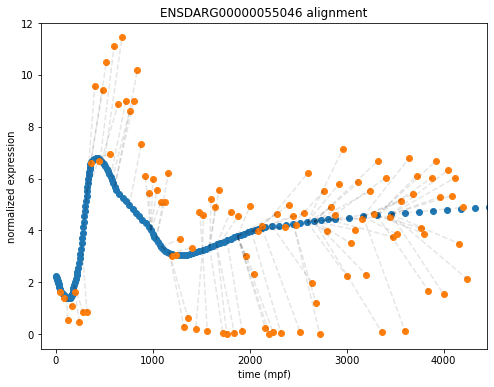

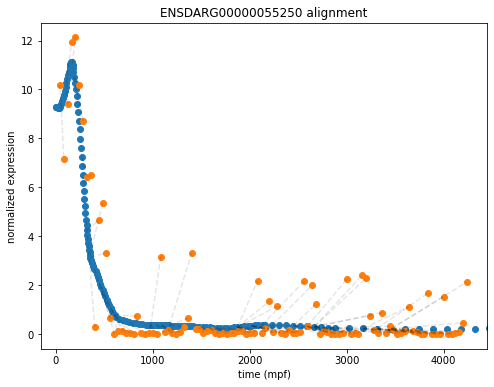

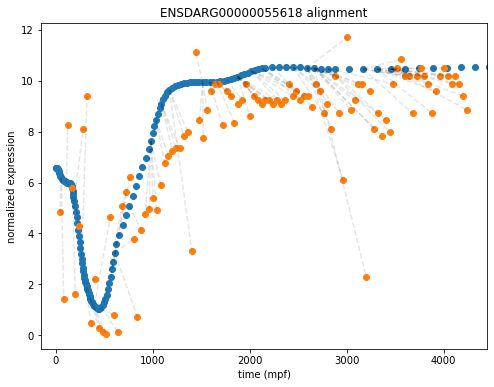

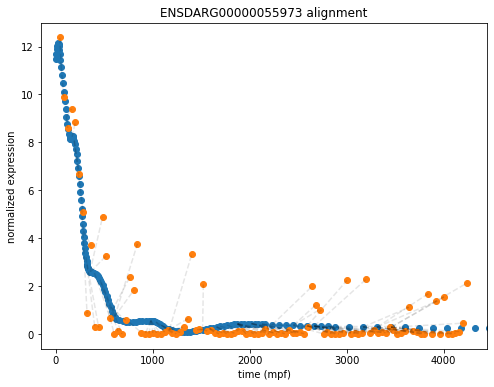

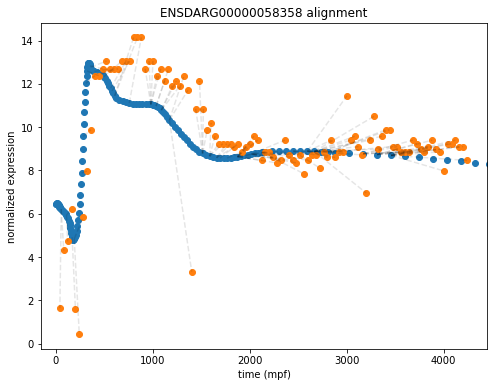

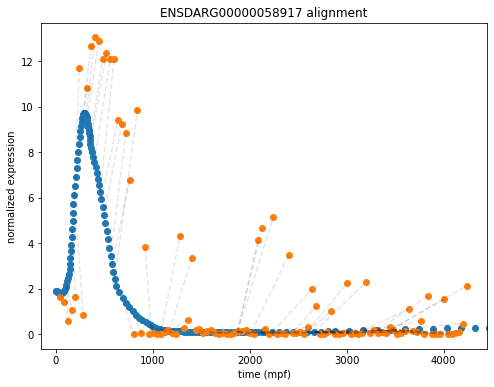

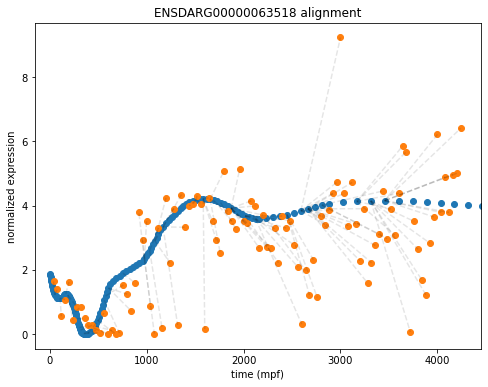

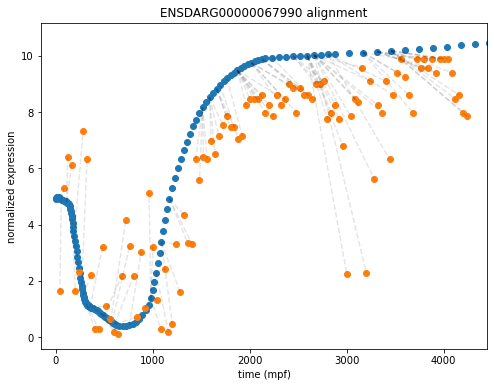

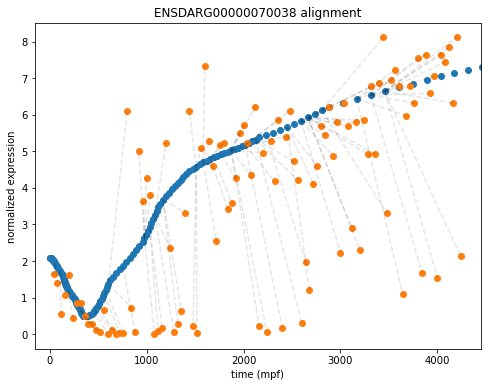

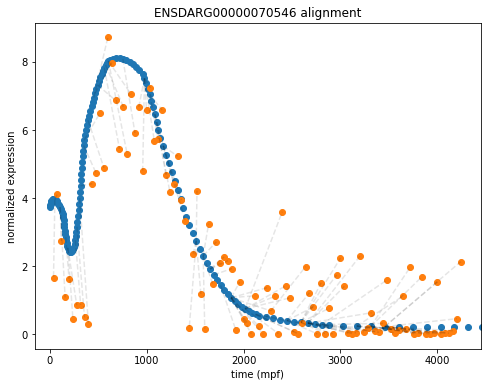

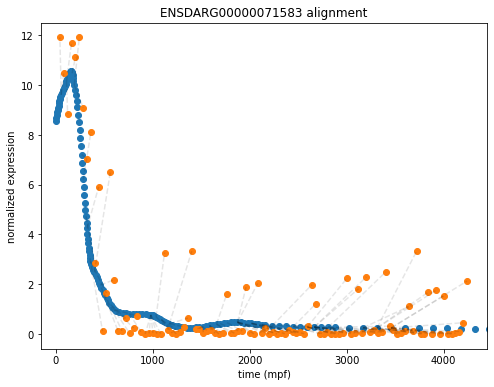

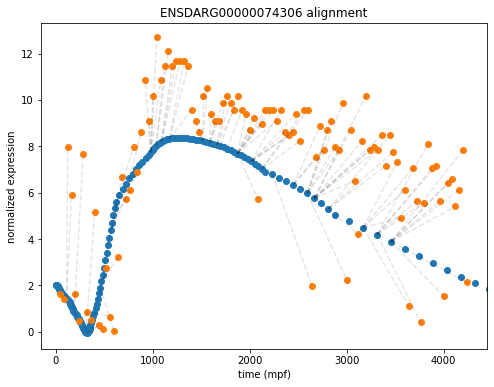

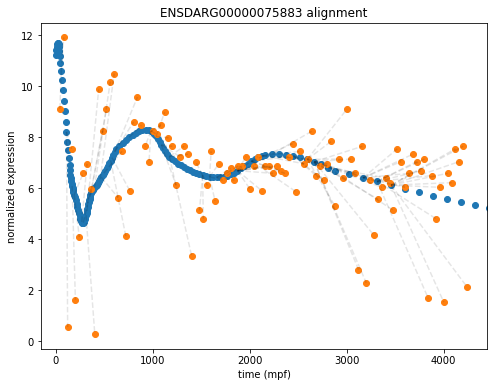

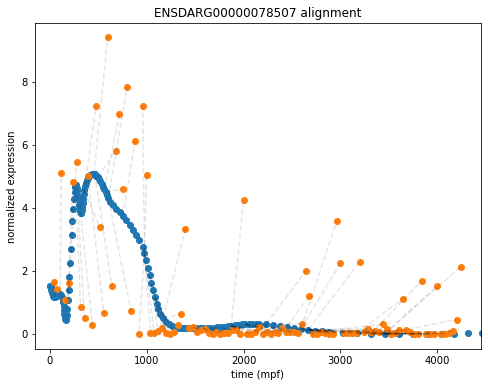

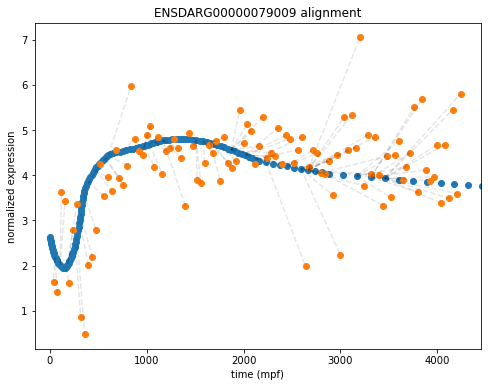

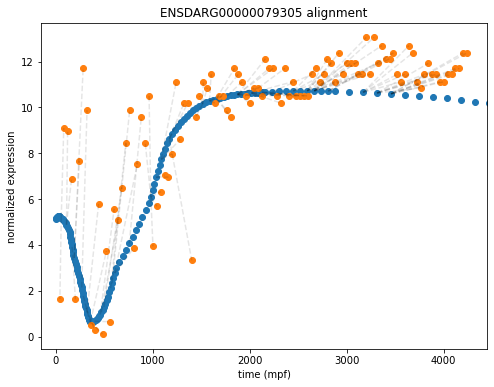

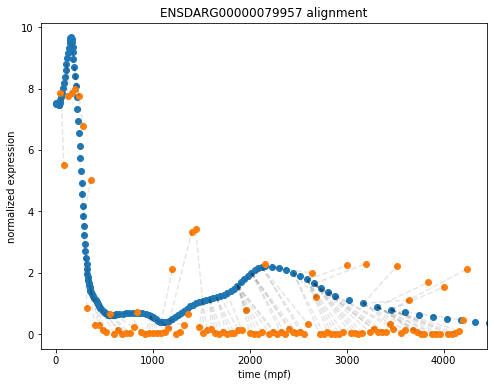

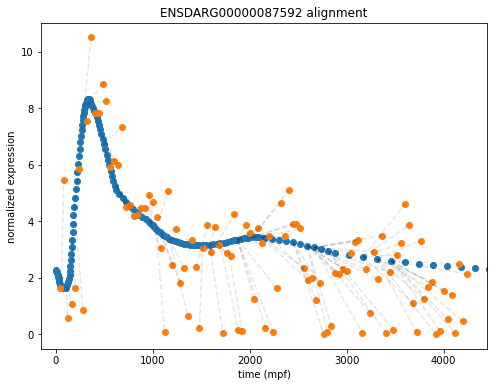

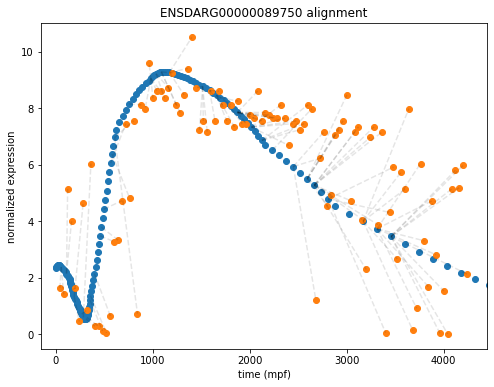

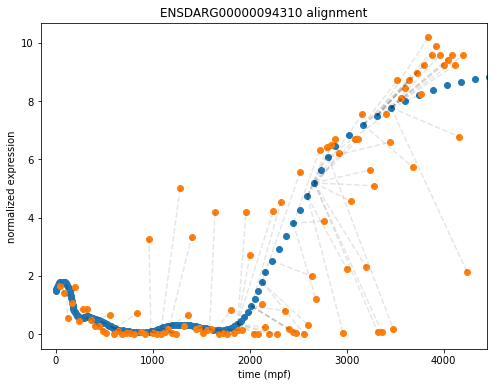

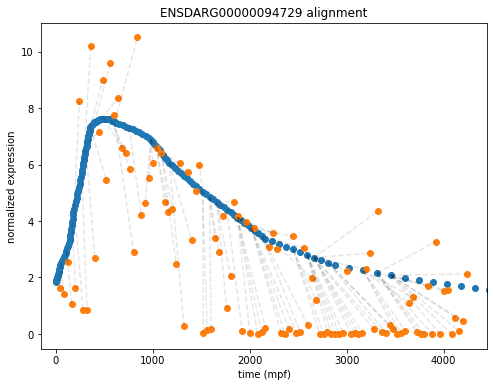

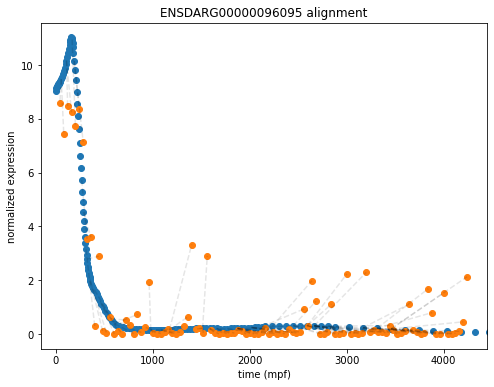

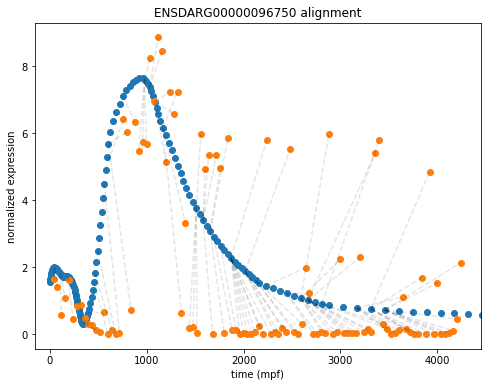

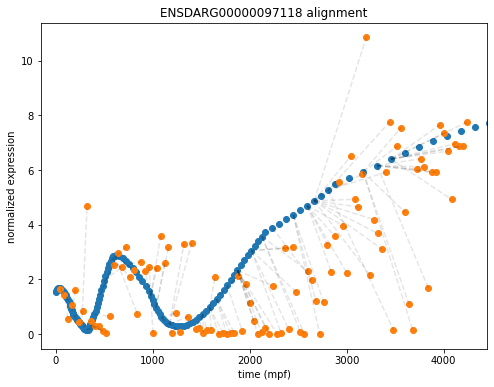

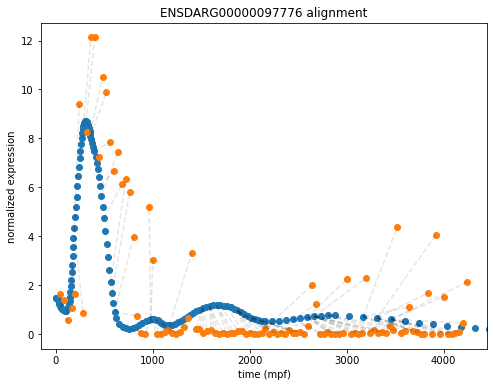

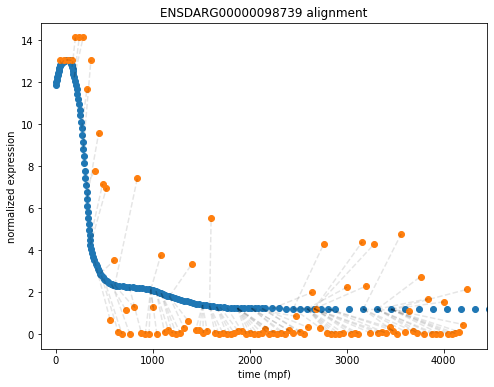

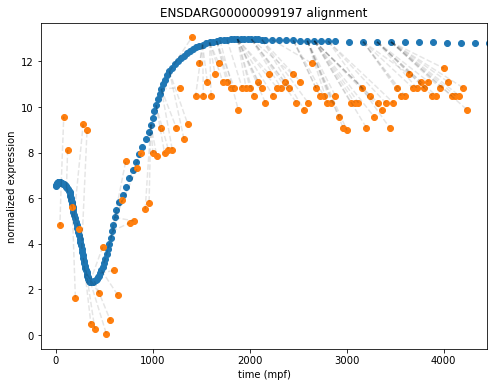

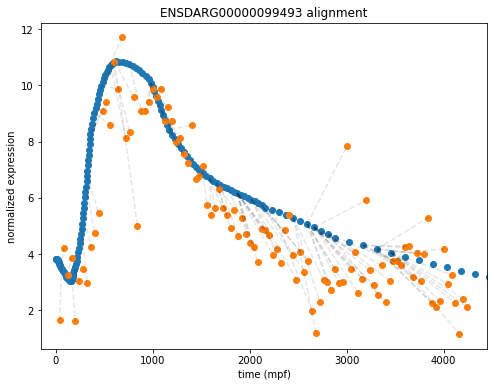

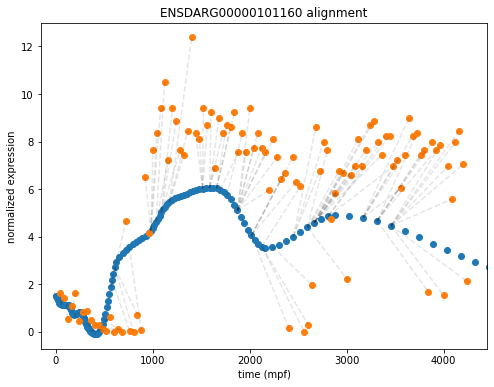

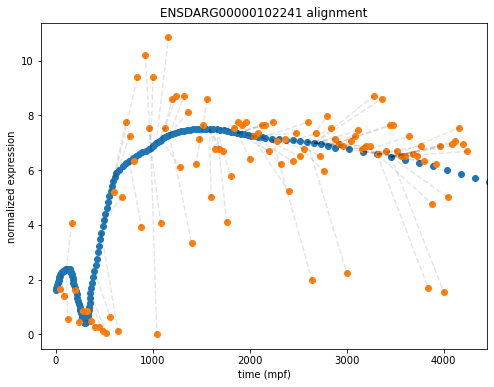

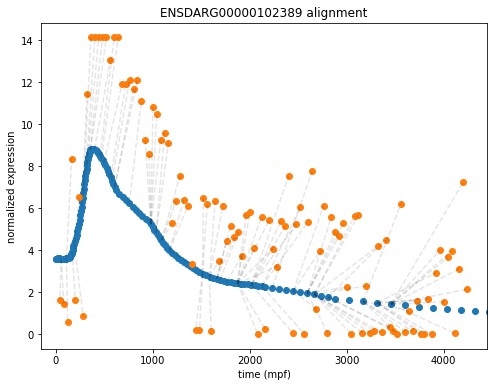

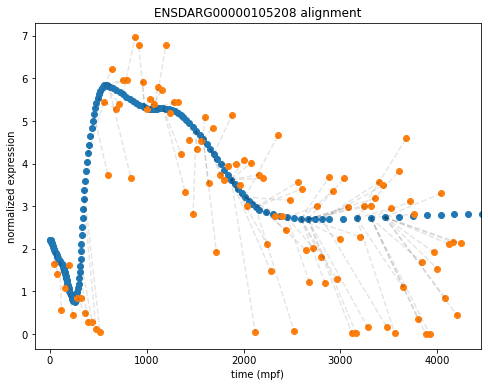

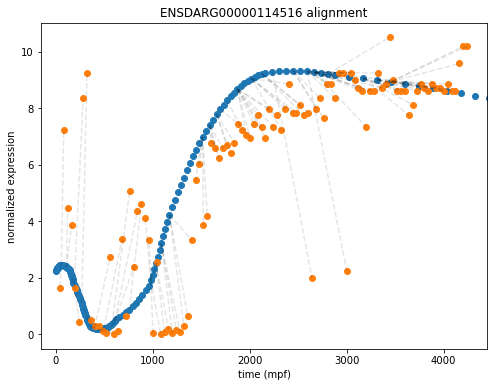

In [288]:
genes =  best_genes_per_cluster  # random.sample(best_genes_per_cluster, 50)

t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
q = query_tpms[query_tpms.index.isin(genes)].rename(columns=samples2time)

query_time = list2floats(query_samples.time.unique())
extended_template_time = list2floats(t.columns)

metrics = ['euclidean'] #, "correlation", "cosine"]
for metric in metrics:
    cost_matrix = get_cost_matrix(t, q, metric)

    # plot heatmap
    # matrix flipped to go from bottom left to top right.
    sns.heatmap(cost_matrix[:,::-1].T)
    plt.show()
    
    # LTSA
    best_path, best_score = best_alignment_graph(cost_matrix)
    
    # plot LTSA
    df = pd.DataFrame(cost_matrix)
    df.columns = t.columns
    df.index = q.columns
    plot_alignment(df, best_path)
    
    # mapping
    mapped = pd.DataFrame(data={
        "original_time": query_time,
        "inferred_time": [extended_template_time[i] for i in best_path],
    })

    # plot alignment
    x1 = extended_template_time
    x2 = query_time
    for gene in q.index:
        y1 = t.loc[gene].to_list()
        y2 = q.loc[gene].to_list() 

        plt.scatter(x=x1, y=y1)
        plt.scatter(x=x2, y=y2)
        for n in range(len(x2)):
            m = best_path[n]
            plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')

        # pretty stuff
        plt.title(f"{gene} alignment")
        plt.ylabel("normalized expression")
        plt.xlabel("time (mpf)")
        start = x1[best_path[0]]
        end = max(x1[best_path[-1]], x2[-1])
        a_bit = (end - start) * 0.05
        plt.xlim(start - a_bit, end + a_bit)
        plt.show()
        
#         break

### gene selection: bootstrap to find best fitting genes (wihtout annotation)

In [ ]:
# do some kind of gene pre-selection

# TSA

# best fitting genes based on TSA output

# TSA

In [164]:
def tpm_normalization(
        tpms: pd.DataFrame,
        column_order: list,
) -> pd.DataFrame:    
    bc = tpms[column_order]                       # filter & order samples    
    
    # default
    bc = quantile_normalize(bc, axis=1)           # normalize
    bc = bc[bc.median(axis=1) > 0.5]
    bc = np.log2(bc+1)                            # transform
    
    return bc
    
query_tpms = tpm_normalization(tpms, sample_order)
query_tpms

GSM1483736  GSM1483737  GSM1483738  GSM1483739  \
gene                                                                 
ENSDARG00000000212    1.643738    4.457585    0.554501    1.076885   
ENSDARG00000001870    1.643738    1.408515    3.739139    1.076885   
ENSDARG00000002445    1.643738    1.408515    3.038309    1.076885   
ENSDARG00000002601    1.643738    1.408515    0.554501    5.683357   
ENSDARG00000002768    5.051852   11.118414   11.700977    9.238173   
...                        ...         ...         ...         ...   
ENSDARG00000110135    1.643738    1.408515    0.554501    1.076885   
ENSDARG00000114516    1.643738    7.239509    4.457585    3.852194   
ENSDARG00000115506    1.643738    1.408515    2.384494    1.076885   
ENSDARG00000115868    1.643738    1.408515    0.554501    1.076885   
ENSDARG00000116617    1.643738    3.966981    0.554501    3.905345   

                    GSM1483740  GSM1483741  GSM1483742  GSM1483743  \
gene                                                                 
ENSDARG00000000212    7.239509    4.764921    8.244308    0.859018   
ENSDARG00000001870    1.624620    0.451006    0.846220    0.859018   
ENSDARG00000002445    1.624620    0.451006    0.846220    0.859018   
ENSDARG00000002601    6.114231    9.238173    0.846220    0.859018   
ENSDARG00000002768    9.238173    6.960623   12.694909   12.694909   
...                        ...         ...         ...         ...   
ENSDARG00000110135    1.624620    0.451006    0.846220    0.859018   
ENSDARG00000114516    1.624620    0.451006    8.349542    9.238173   
ENSDARG00000115506    5.911201    8.858922    0.846220    8.349542   
ENSDARG00000115868    1.624620    0.451006    0.846220    0.859018   
ENSDARG00000116617    1.624620    2.430417    3.240683    3.017477   

                    GSM1483744  GSM1483745  ...  GSM1483832  GSM1483833  \
gene                                        ...                           
ENSDARG00000000212    0.487315   11.918621  ...    7.449232    7.843114   
ENSDARG00000001870    0.487315    0.283169  ...    4.806622    4.457585   
ENSDARG00000002445    0.487315    0.283169  ...    1.144532    2.180788   
ENSDARG00000002601    0.487315    3.510424  ...    4.057614    3.852194   
ENSDARG00000002768    2.590499    5.051852  ...   14.142893   13.051216   
...                        ...         ...  ...         ...         ...   
ENSDARG00000110135    0.487315    0.283169  ...   12.378737   12.378737   
ENSDARG00000114516    0.487315    0.283169  ...    8.858922    8.719400   
ENSDARG00000115506    6.960623    6.682845  ...    0.003325    0.004132   
ENSDARG00000115868    0.487315    3.878233  ...    2.865132    1.180752   
ENSDARG00000116617    3.038309    3.088309  ...    2.664564    2.364106   

                    GSM1483834  GSM1483835  GSM1483836  GSM1483837  \
gene                                                                 
ENSDARG00000000212    8.116623    8.349542    8.244308    7.146577   
ENSDARG00000001870    4.347703    1.531869    4.494971    3.038309   
ENSDARG00000002445    2.590499    1.531869    1.087324    2.737952   
ENSDARG00000002601    4.494971    1.531869    3.113324    2.783649   
ENSDARG00000002768   14.142893   12.694909   13.051216   13.051216   
...                        ...         ...         ...         ...   
ENSDARG00000110135   11.700977    1.531869   14.142893   12.694909   
ENSDARG00000114516    8.719400    8.601233    8.858922    8.601233   
ENSDARG00000115506    0.078799    1.531869    0.448676    0.001348   
ENSDARG00000115868    0.143269    1.531869    0.266094    0.001348   
ENSDARG00000116617    2.783649    1.531869    1.755415    2.384494   

                    GSM1483838  GSM1483839  GSM1483840  GSM1483841  
gene                                                                
ENSDARG00000000212    8.244308    7.648150    0.451006    9.102152  
ENSDARG00000001870    4.309342    4.564541    5.134746    2.127221  
ENSDARG00000002445    1.969078    2

In [35]:
gene_set = query_tpms.index.to_list()
print("genes:", len(gene_set))

genes: 264


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


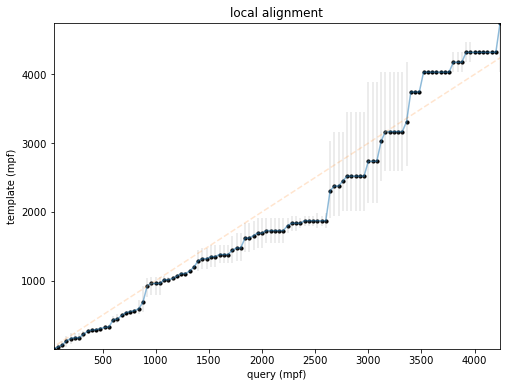

In [37]:
# bootstrap 1: find the average alignment

tries = 10
subset = 100

paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%")
    genes = random.sample(gene_set, subset)

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)].rename(columns=samples2time)

    cost_matrix = get_cost_matrix(t, q, metric='euclidean')
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path
    
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]
        
# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
plot_alignment(c, avg_path, std_path2)

In [38]:
# best fitting query genes 1

named_query = query_tpms.rename(columns=samples2time)
# required_template_points = np.array([template_tpms_inf.to_numpy()[:, i] for i in avg_path]).T

scores = [] 
for gene in gene_set:
    template_y = [template_tpms_inf.loc[gene].to_list()[i] for i in avg_path]
#     template_y = np.array([template_tpms_inf.to_numpy()[:, i] for i in avg_path]).T
    query_y = named_query.loc[gene].to_list()
    # how close are the two time series? (argument order is arbitrary)
    scores.append(sklearn.metrics.r2_score(y_true=query_y, y_pred=template_y))
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html  
    
best_fitting_genes = pd.DataFrame({"gene": gene_set, "score": scores}).sort_values("score", ascending=False)
gene_set = best_fitting_genes.head(int(len(gene_set)*0.8)).gene.to_list()

print("genes:",len(gene_set))
best_fitting_genes.head(3)

genes: 211


gene     score
83   ENSDARG00000035957  0.712901
152  ENSDARG00000058358  0.648818
172  ENSDARG00000070546  0.644331

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


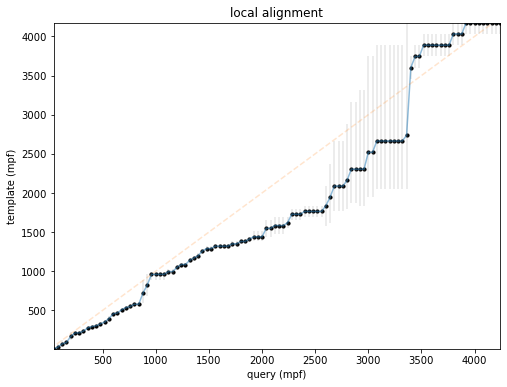

In [39]:
# bootstrap 2

tries = 10
subset = 100

paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%")
    genes = random.sample(gene_set, subset)

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)].rename(columns=samples2time)

    cost_matrix = get_cost_matrix(t, q, metric='euclidean')
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path
    
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]
        
# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
plot_alignment(c, avg_path, std_path2)

In [40]:
# best fitting query genes 2

named_query = query_tpms.rename(columns=samples2time)
# required_template_points = np.array([template_tpms_inf.to_numpy()[:, i] for i in avg_path]).T

scores = [] 
for gene in gene_set:
    template_y = [template_tpms_inf.loc[gene].to_list()[i] for i in avg_path]
#     template_y = np.array([template_tpms_inf.to_numpy()[:, i] for i in avg_path]).T
    query_y = named_query.loc[gene].to_list()
    # how close are the two time series? (argument order is arbitrary)
    scores.append(sklearn.metrics.r2_score(y_true=query_y, y_pred=template_y))
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html  
    
best_fitting_genes = pd.DataFrame({"gene": gene_set, "score": scores}).sort_values("score", ascending=False)
gene_set = best_fitting_genes.head(int(len(gene_set)*0.8)).gene.to_list()

print("genes:",len(gene_set))
best_fitting_genes.head(3)

genes: 168


gene     score
0  ENSDARG00000035957  0.692630
1  ENSDARG00000058358  0.676143
3  ENSDARG00000030270  0.645088

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


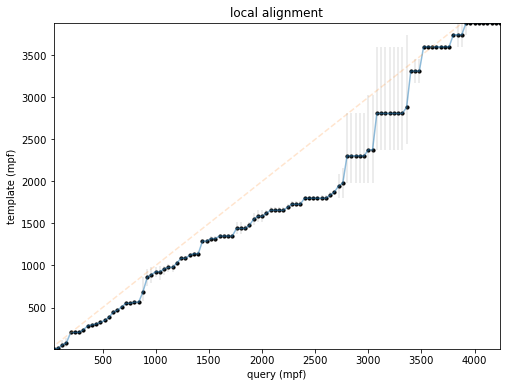

In [41]:
# bootstrap 3

tries = 10
subset = 100

paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%")
    genes = random.sample(gene_set, subset)

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)].rename(columns=samples2time)

    cost_matrix = get_cost_matrix(t, q, metric='euclidean')
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path
    
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]
        
# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
plot_alignment(c, avg_path, std_path2)

In [42]:
# best fitting query genes 3

named_query = query_tpms.rename(columns=samples2time)
# required_template_points = np.array([template_tpms_inf.to_numpy()[:, i] for i in avg_path]).T

scores = [] 
for gene in gene_set:
    template_y = [template_tpms_inf.loc[gene].to_list()[i] for i in avg_path]
#     template_y = np.array([template_tpms_inf.to_numpy()[:, i] for i in avg_path]).T
    query_y = named_query.loc[gene].to_list()
    # how close are the two time series? (argument order is arbitrary)
    scores.append(sklearn.metrics.r2_score(y_true=query_y, y_pred=template_y))
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html  
    
best_fitting_genes = pd.DataFrame({"gene": gene_set, "score": scores}).sort_values("score", ascending=False)
gene_set = best_fitting_genes.head(int(len(gene_set)*0.8)).gene.to_list()

print("genes:",len(gene_set))
best_fitting_genes.head(3)

genes: 134


gene     score
0  ENSDARG00000035957  0.688550
1  ENSDARG00000058358  0.675415
2  ENSDARG00000030270  0.647738

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


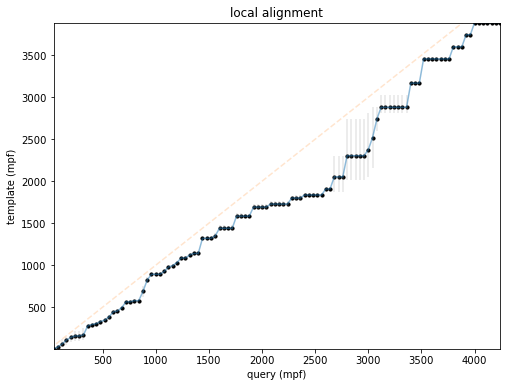

In [43]:
# bootstrap 4

tries = 10
subset = 100

paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%")
    genes = random.sample(gene_set, subset)

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)].rename(columns=samples2time)

    cost_matrix = get_cost_matrix(t, q, metric='euclidean')
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path
    
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]
        
# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
plot_alignment(c, avg_path, std_path2)

In [44]:
# best fitting query genes 4

named_query = query_tpms.rename(columns=samples2time)
# required_template_points = np.array([template_tpms_inf.to_numpy()[:, i] for i in avg_path]).T

scores = [] 
for gene in gene_set:
    template_y = [template_tpms_inf.loc[gene].to_list()[i] for i in avg_path]
#     template_y = np.array([template_tpms_inf.to_numpy()[:, i] for i in avg_path]).T
    query_y = named_query.loc[gene].to_list()
    # how close are the two time series? (argument order is arbitrary)
    scores.append(sklearn.metrics.r2_score(y_true=query_y, y_pred=template_y))
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html  
    
best_fitting_genes = pd.DataFrame({"gene": gene_set, "score": scores}).sort_values("score", ascending=False)
gene_set = best_fitting_genes.head(int(len(gene_set)*0.8)).gene.to_list()

print("genes:",len(gene_set))
best_fitting_genes.head(3)

genes: 107


gene     score
0  ENSDARG00000035957  0.699291
1  ENSDARG00000058358  0.650710
3  ENSDARG00000114516  0.641656

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


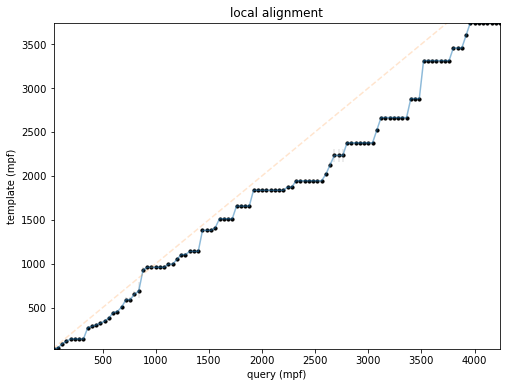

In [45]:
# bootstrap 5

tries = 10
subset = 100

paths = np.zeros((tries, query_tpms.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%")
    genes = random.sample(gene_set, subset)

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)].rename(columns=samples2time)

    cost_matrix = get_cost_matrix(t, q, metric='euclidean')
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path
    
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]
        
# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
plot_alignment(c, avg_path, std_path2)

### bootstrap /w clustering

In [37]:
def tpm_normalization(
        tpms: pd.DataFrame,
        column_order: list,
) -> pd.DataFrame:    
    bc = tpms[column_order]                       # filter & order samples    
    
    # default
    bc = quantile_normalize(bc, axis=1)           # normalize
#     bc = bc[bc.median(axis=1) > 0.5]
    bc = np.log2(bc+1)                            # transform
    
    return bc
    
    
query_tpms = tpm_normalization(tpms, sample_order)
query_tpms = query_tpms.rename(columns=samples2time)

fraction = 0.8

query_intermediate = query_tpms
n_clusters = max(10, int(len(query_intermediate)/20))
print("n_genes:", len(query_intermediate))
print("n_clusters:", n_clusters)

reduced_query_tpms = PCA(n_components=2).fit_transform(query_tpms)

n_genes: 501
n_clusters: 25


0%
10%
20%
30%
40%
50%
60%
70%
80%
90%


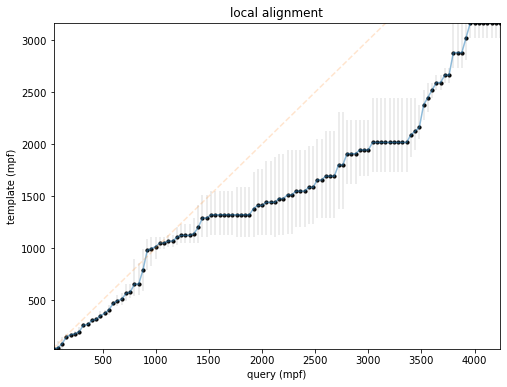

In [55]:
tsa_fraction = 0.2  # use this % of genes per cluster for TSA
tries = 10

# K-means on PCA
reduced_data = PCA(n_components=2).fit_transform(query_intermediate)
k = k_means(reduced_data, n_clusters)[1]
gene_clusters = pd.DataFrame({"gene": query_intermediate.index, "cluster": k})

# TSA on subset per cluster
paths = np.zeros((tries, query_intermediate.shape[1]))
for n in range(tries):
    print(f"{int(100*n/tries)}%")
    
    # get a fraction of genes per cluster
    genes = gene_clusters.groupby("cluster").sample(frac=tsa_fraction).gene.to_list()

    t = template_tpms_inf[template_tpms_inf.index.isin(genes)]
    q = query_tpms[query_tpms.index.isin(genes)]
    
    cost_matrix = get_cost_matrix(t, q, metric='euclidean')
    best_path, best_score = best_alignment_graph(cost_matrix)

    paths[n] = best_path

# average path of TSAs
avg_path = [int(i) for i in paths.mean(axis=0)]
# if the average timepoint is later that the previous timepoint, increase it to match
for n in range(1, len(avg_path)):
    if avg_path[n-1] > avg_path[n]:
        avg_path[n] = avg_path[n-1]
        
# std of average path
std_path = [int(i) for i in paths.std(axis=0)]
std_path2 = []
extended_template_time = list2floats(t.columns)
for n, p in enumerate(avg_path):
    inf_time = extended_template_time[p]
    std_time_min = abs(extended_template_time[max(0, p - std_path[n])]-inf_time)
    std_time_max = abs(extended_template_time[min(p + std_path[n], len(extended_template_time)-1)]-inf_time)
    std_path2.append([std_time_min, std_time_max])
std_path2 = np.array(std_path2).T

# plot
c = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
plot_alignment(c, avg_path, std_path2)

# get R2 scores
gene_set = query_tpms.index.to_list()
scores = [] 
for gene in gene_set:
    template_y = [template_tpms_inf.loc[gene].to_list()[i] for i in avg_path]
    query_y = query_tpms.loc[gene].to_list()
    
    # how close are the two time series? (argument order is arbitrary)
    scores.append(sklearn.metrics.r2_score(y_true=query_y, y_pred=template_y))

In [227]:
# fraction = 0.8

# best_fitting_genes = pd.DataFrame({"gene": gene_set, "score": scores}).sort_values("score", ascending=False)
# best_fitting_genes = best_fitting_genes[best_fitting_genes.score > 0]
# best_fitting_genes = best_fitting_genes.merge(gene_clusters, on="gene")
# # best_fitting_genes
# # best_fitting_genes.head(3)

# # subset per cluster by fit
# subset = best_fitting_genes.copy().groupby("cluster").apply(lambda x: x.head(int(len(x)*0.8))).reset_index(drop=True)
# # subset.groupby("cluster").describe()
# subset = subset.gene.to_list()

# # # subset over all genes by fit
# # subset = best_fitting_genes.head(int(len(best_fitting_genes) * fraction)).gene.to_list()

# query_intermediate = query_intermediate[query_intermediate.index.isin(subset)]
# n_clusters = max(10, int(len(query_intermediate)/20))
# print("n_genes:", len(query_intermediate))
# print("n_clusters:", n_clusters)

n_genes: 64
n_clusters: 10


In [53]:
# subset per cluster by fit

# combine score and cluster info per gene
subset = pd.DataFrame({"gene": gene_set, "score": scores})
subset = subset.merge(gene_clusters, on="gene", how="right")
subset.sort_values("score", ascending=False, inplace=True)
print("mean fit score:", subset.score.mean())
s = subset.groupby("cluster").score.mean()
g = subset.groupby("cluster").size()
g.name = "n_genes"
print("mean fit score per cluster\n", pd.concat([s, g], axis=1))

# take the top fraction of each cluster to train a new k-means
subset = subset.groupby("cluster").apply(lambda x: x.head(int(len(x)*fraction))).reset_index(drop=True)  # top fraction/cluster
subset = subset[subset.score > 0]  # minimum score
subset.sort_values("score", ascending=False, inplace=True)
subset = subset.gene.to_list()

training_df = query_tpms[query_tpms.index.isin(subset)]
training_data = PCA(n_components=2).fit_transform(training_df)
n_clusters = max(10, int(len(training_data)/20))
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
kmeans.fit(training_data)

# cluster all query genes based on the best genes this round
k = kmeans.predict(reduced_query_tpms)
subset = pd.DataFrame({"gene": gene_set, "score": scores})
gene_clusters2 = pd.DataFrame({"gene": query_tpms.index, "cluster": k})
subset = subset.merge(gene_clusters2, on="gene", how="right")
subset.sort_values("score", ascending=False, inplace=True)
print("mean fit score:", subset.score.mean())
s = subset.groupby("cluster").score.mean()
g = subset.groupby("cluster").size()
g.name = "n_genes"
print("mean fit score per cluster\n", pd.concat([s, g], axis=1))

mean fit score: -4.3030631892152025
mean fit score per cluster
             score  n_genes
cluster                   
0       -1.128567       31
1       -0.445908        6
2       -5.391155       17
3       -5.551777       48
4       -9.061736      117
5        0.134901       10
6        0.347901        7
7       -1.701952       12
8        0.410507        3
9       -2.080597       10
10       0.158357        2
11      -4.790027       26
12       0.486445       12
13      -0.262524       11
14       0.162261        5
15      -3.486951       17
16      -0.769379        1
17       0.316828        7
18      -2.612167       17
19      -1.845555       18
20      -3.170678       52
21      -0.673397       15
22       0.135822        6
23       0.250772        6
24      -5.222792       45
mean fit score: -4.3030631892152025
mean fit score per cluster
             score  n_genes
cluster                   
0       -1.617199       35
1        0.042181       24
3       -1.559121       20
4       

In [54]:
# take the top fraction of each cluster for the next round of TSA
fraction = min(fraction - 0.2, 0.1)
print("using", int(fraction*100), "% of genes")

subset = subset.groupby("cluster").apply(lambda x: x.head(int(len(x)*fraction))).reset_index(drop=True)  # top fraction/cluster
print("mean fit score:", subset.score.mean())
s = subset.groupby("cluster").score.mean()
g = subset.groupby("cluster").size()
g.name = "n_genes"
print("mean fit score per cluster\n", pd.concat([s, g], axis=1))
subset = subset.gene.to_list()

# # # # subset over all genes by fit
# # # subset = best_fitting_genes.head(int(len(best_fitting_genes) * fraction)).gene.to_list()

query_intermediate = query_tpms[query_tpms.index.isin(subset)]
n_clusters = max(10, int(len(query_intermediate)/20))
print("n_genes:", len(query_intermediate))
print("n_clusters:", n_clusters)

using 10 % of genes
mean fit score: 0.3021840621132739
mean fit score per cluster
             score  n_genes
cluster                   
0        0.596147        3
1        0.622912        2
3        0.589267        2
4       -0.087490        6
5        0.296869        9
6        0.679052        1
8       -0.025621       13
9        0.719481       10
n_genes: 46
n_clusters: 10


### gene selection: Joost + Jos (+ Maarten?)

In [ ]:
# Cluster

# best fitting per cluster (without using annotation)

# TSA

# (100 x random subset)

In [ ]:
# # preprocessing
# selected_genes = list(pd.read_csv(selected_genes_file, sep="\t")["gene"])

# template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
# template_tpms_inf = template_tpms_inf[template_tpms_inf.index.isin(selected_genes)]

# query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
# sample_order, time2samples = get_sample_info(query_samples)

# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
# query_tpms = tpm_normalization(tpms, sample_order)
# query_tpms = query_tpms[query_tpms.index.isin(selected_genes)]

In [ ]:
# # preprocessing
# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
# selected_genes = list(pd.read_csv(selected_genes_file, sep="\t")["gene"])
# tpms = tpms[tpms.index.isin(selected_genes)]
# timepoints_per_sample = 10

# query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
# sample_order, time2samples = get_sample_info(query_samples)
# query_tpms = tpm_normalization(tpms, sample_order)

# template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
# template_sample_order, template_time2samples = get_sample_info(template_samples)
# template_tpms = tpm_normalization(tpms, template_sample_order)


# # plot normalized TPMs
# good_genes = ["ENSDARG00000000212", "ENSDARG00000002768", "ENSDARG00000004232", "ENSDARG00000005023", "ENSDARG00000006110", "ENSDARG00000006427"]
# bad_genes = ["ENSDARG00000002165", "ENSDARG00000002445", "ENSDARG00000002601"]
# genes = good_genes[0:2] + bad_genes[0:2]
# # genes = good_genes

# # average replicates
# t = template_tpms.copy()
# for timepoint in template_time2samples:
#     t[timepoint] = t[template_time2samples[timepoint]].mean(axis=1)
# t = t.filter(items=template_time2samples.keys())
# x_template = list(template_time2samples)[:-2]

# x_query = list(time2samples)
# for gene in genes:  # query_tpms.index: #
#     y_template = t.loc[gene].to_list()[:-2]
#     plt.scatter(x=x_template, y=y_template)
    
#     y_query = query_tpms.loc[gene]
#     plt.scatter(x=x_query, y=y_query)
    
#     plt.title(gene)
#     plt.ylabel("normalized expression")
#     plt.xlabel("annotated time (mpf)")
#     plt.show()